In [1]:
# 필요할 모듈

In [2]:
import pandas as pd
import os
import dask.dataframe as dd
import math
import datetime
import random
import time
from dask.diagnostics import ProgressBar # dask, 진행 현황 확인용
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings #경고 미출력
warnings.filterwarnings('ignore')
from matplotlib import font_manager, rc # Font 설정
font_name = font_manager.FontProperties(fname="/System/Library/Fonts/Supplemental/AppleMyungjo.ttf").get_name()
rc('font', family=font_name)
palette = sns.color_palette('twilight') + sns.color_palette('bright')
pd.options.display.float_format = '{:.f}'.format # 값의 길이로 인한 생략을 없애는 옵션

### 사용할 데이터 불러오기

In [3]:
bus_2018 = dd.read_csv("data/버스 승객별 이용 현황_2018.csv",
                 dtype={'getoff_datetime': 'float64','getoff_station_id': 'float64'})
bus_2019 = dd.read_csv("data/버스 승객별 이용 현황_2019.csv",
                 dtype={'getoff_datetime': 'float64','getoff_station_id': 'float64'})

In [4]:
bus_total = dd.concat([bus_2018, bus_2019], axis=0)

### 데이터 확인하기
#### 1. 버스 승객별 이용 현황 : 2018, 2019
    - 기간 : 2018년 07월 01일 ~ 2019년 12월 31일
    - row : 1회의 탑승 기록, 총 77,152,333 회의 탑승값

In [10]:
# DataFrame Shape
bus_total.tail()

ValueError: Format specifier missing precision

ValueError: Format specifier missing precision

In [9]:
# DataFrame Columns
bus_total.columns

Index(['base_date', 'user_id', 'route_id', 'route_name', 'route_no',
       'geton_datetime', 'geton_station_id', 'geton_stataion_name',
       'geton_station_longitude', 'geton_station_latitude', 'getoff_datetime',
       'getoff_station_id', 'getoff_station_name', 'getoff_station_longitude',
       'getoff_station_latitude', 'user_type', 'user_count', 'pt_year',
       'pt_month'],
      dtype='object')

In [ ]:
# Data Inforation

In [13]:
bus_total.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77152333 entries, 0 to 21356
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   base_date                 int64  
 1   user_id                   object 
 2   route_id                  int64  
 3   route_name                object 
 4   route_no                  object 
 5   geton_datetime            int64  
 6   geton_station_id          int64  
 7   geton_stataion_name       object 
 8   geton_station_longitude   float64
 9   geton_station_latitude    float64
 10  getoff_datetime           float64
 11  getoff_station_id         float64
 12  getoff_station_name       object 
 13  getoff_station_longitude  float64
 14  getoff_station_latitude   float64
 15  user_type                 object 
 16  user_count                int64  
 17  pt_year                   int64  
 18  pt_month                  int64  
dtypes: float64(6), int64(7), object(6)
memory usage: 11.5+ GB


In [14]:
# Data description : total date counts, total bus route counts, total bus stop counts
total_des = bus_total[["base_date", "route_no", "geton_station_id"]].compute().nunique()
total_des

base_date            547
route_no             790
geton_station_id    3877
dtype: int64

In [15]:
# Data description : total user counts, total user.unique() counts 
total_len = len(bus_total["user_id"].compute())
uniq_user = bus_total["user_id"].compute().nunique()
total_len,  uniq_user

(77152333, 2400594)

#### Data Info.
- date
    - 547 days | 018.07.01 ~ 2019.12.31
- User
    - Unique User : 2,400,000
    - Total User : 77,152,333
- Bus Route
    - 790 (2018 ~ 2019 Total Operating)
- Bus Stop
    - 3,877 (2018 ~ 2019 Total Operating)

#### More Information about Bus Route 
- 2018년 기준으로 공식 노선 수는 약 200여개였으나,
- 분기노선 혹은 현재는 통합/폐합된 노선들이 전부 개별 노선으로 기록되어있어,
- 실제보다 많은 노선이 기록되어있음
-  인당 평균 승차 수 = total user.unique() counts / total user counts

In [ ]:
# Bus Using Description 
total_des = pd.DataFrame(total_des)
total_des.columns = ["number"]
total_des.loc["전체 row 수(버스 탑승횟수)", "number"] = total_len
total_des.loc["고유 승차객 수", "number"] = uniq_user
total_des.loc["인당 평균 승차 수", "number"] = round(total_len/uniq_user, 2)
total_des.rename(index={"base_date":"기준일", "route_no":"노선 수", "geton_station_id":"정류장 수"}, inplace=True)
total_des.astype(int)

In [ ]:
# User Description
user_counts = bus_total["user_id"].compute().value_counts()
user_counts = pd.DataFrame(user_counts)
user_counts.rename(columns={"user_id":"counts"}, inplace=True)
user_counts["order"] = list(range(len(user_counts)))
user_counts.head()

In [ ]:
user_counts["counts"].describe()

#### 승차 횟수의 분포 
- mean         32
- std         105
- min           1
- 25%           2
- 50%           5
- 75%          13
- max        4618

#### More Informataion
- 인당 평균 승차 수는 32회였으나, 중앙값은 5회로 버스 승객 간 승차 횟수의 편차가 큰 편
- 2018년 기준으로 제주도민의 인구 수는 69만 2천여명으로,
- 2018년~2019년의 고유 승차객 숫자가 240만명인 것을 함께 고려하면
- 대중교통을 이용한 외부 유입자 수(관광객)가 많아
- 평균 승차 수의 불균형 또한 심하게 나타났다고 볼 수 있음

In [ ]:
# User Using Counts Graph
plt.figure(figsize=(10, 5))
plt.violinplot(user_counts["counts"], vert=False, showmeans=True)
plt.text(x=10, y=1.2, s="average:{}, median:{}".format(round(user_counts["counts"].mean(), 2), \
                                                       user_counts["counts"].median()),
        fontsize=15)
plt.show()

### Preprocessing

#### 정류소 데이터
- 정류소의 위도/경도 값을 이용하여 카카오 api에서 시/동/읍면리의 행정구역을 추가한 데이터

In [17]:
bus_station = pd.read_csv('data/station_address.csv', encoding='utf-8-sig')

In [18]:
bus_station.head(2)

ValueError: Format specifier missing precision

ValueError: Format specifier missing precision

#### 정류소의 행정구역을 기준으로 지역과 관광지역을 분류해주는 cluster1,2, tour_cluster 생성하기

In [19]:
# 섬속의 섬 버리기 (우도, 추자도)
cowdo = bus_station[bus_station['dong'] == '우도면']
dancedo = bus_station[bus_station['dong'] == '추자면']
island = pd.concat([cowdo, dancedo], axis=0)
bus_station = bus_station[bus_station.index.isin(island.index) == False]

In [28]:
# 클러스터 컬럼 만들어주기(정류소 동/리)

In [20]:
구제주_탑동 = ['건입동', '일도일동', '삼도이동']
구제주 = ['일도이동', '삼도일동', '이도일동', '이도이동', '도남동']
용담해안도로 = ['용담일동', '용담이동', '용담삼동', '도두일동', '도두이동', '이호일동', '이호이동']
제주시_버스터미널 = ['오라일동']
구제주_오라동 = ['오라이동' , '오라삼동']
아라동 = ['아라일동', '아라이동']
첨단과학기술단지 = ['영평동', '월평동']
삼화지구 = ['화북일동', '화북이동', '삼양일동', '삼양이동', '삼양삼동', '도련일동', '도련이동']
신제주 = ['연동', '노형동']
외도지구 = ['외도일동', '외도이동', '도평동', '내도동']
봉개 = ['봉개동']
제주시_중산간 = ['오등동', '회천동', '용강동']
함덕 = ['신촌리', '함덕리', '북촌리', '조천리']
조천_중산간 = ['와흘리', '대흘리', '와산리', '선흘리']
김녕 = ['동복리', '김녕리']
월정 = ['월정리', '행원리', '한동리', '평대리']
세화 = ['세화리', '상도리', '하도리', '종달리']
구좌_중산간 = ['덕천리', '송당리']
남조로 = ['교래리', '가시리', '수망리']
성산일출봉_섭지코지 = ['시흥리', '오조리', '성산리', '고성리', '온평리']
성산_중산간 = ['수산리', '난산리']
성산 = ['신천리', '신풍리', '삼달리', '신산리']
성읍 = ['성읍리']
표선해수욕장 = ['하천리', '표선리']
표선 = ['토산리']
남원 = ['신흥리', '태흥리', '남원리', '의귀리']
남원_중산간 = ['한남리']
위미 = ['위미리', '하례리', '신례리']
서귀포_구시가지 = ['동홍동', '서홍동', '중앙동', '서귀동', '천지동']
서귀포_신시가지 = ['대륜동', '강정동', '서호동']
서귀포시_동부 = ['토평동', '신효동', '호근동', '보목동', '하효동']
서귀포시_중산간 = ['영남동', '하원동', '상효동', '회수동', '도순동']
서귀포시_법환포구 = ['법환동']
중문 = ['중문동', '색달동', '대포동', '상예동', '하예동']
사계 = ['창천리', '감산리', '화순리', '사계리', '덕수리']
안덕_중산간 = ['광평리', '상창리', '상천리']
안덕_동서광 = ['동광리', '서광리']
모슬포 = ['상모리', '인성리', '하모리', '동일리']
대정 = ['일과리', '영락리', '신평리', '안성리', '신도리', '무릉리']
영어교육도시 = ['구억리', '보성리']
한경_중산간 = ['청수리', '조수리', '낙천리', '저지리']
차귀 = ['고산리', '용수리']
신창 = ['두모리', '신창리']
판포 = ['금등리', '판포리']
협재 = ['협재리', '금능리', '월령리']
한림 = ['옹포리', '동명리', '한림리', '대림리', '수원리', '귀덕리', '한수리']
한림_중산간 = ['월림리', '상명리', '금악리', '명월리', '상대리']
곽지 = ['금성리', '곽지리']
애월_중산간 = ['남읍리', '어음리', '상가리', '유수암리', '소길리', '광령리', '고성리', '상귀리', '장전리', '납읍리', '봉성리', '해안동']
애월 = ['애월리', '하가리', '고내리', '신엄리', '구엄리', '수산리']
하귀 = ['하귀1리', '하귀2리']

cluster_list = [구제주_탑동, 구제주, 용담해안도로, 제주시_버스터미널, 구제주_오라동, 아라동, 첨단과학기술단지, 삼화지구, 신제주, 외도지구, 봉개, 제주시_중산간, 함덕, 조천_중산간,
               김녕, 월정, 세화, 구좌_중산간, 남조로, 성산일출봉_섭지코지, 성산_중산간, 성산, 성읍, 표선해수욕장, 표선, 남원, 남원_중산간,
               위미, 서귀포_구시가지, 서귀포_신시가지, 서귀포시_동부, 서귀포시_중산간, 서귀포시_법환포구, 중문, 사계, 안덕_중산간, 안덕_동서광, 모슬포, 대정, 
               영어교육도시, 한경_중산간, 차귀, 신창, 판포, 협재, 한림, 한림_중산간, 곽지, 애월_중산간, 애월, 하귀]
cluster_name = ['구제주_탑동', '구제주', '용담해안도로', '제주시_버스터미널', '구제주_오라동', '아라동', '첨단과학기술단지', '삼화지구', '신제주', '외도지구', '봉개', '제주시_중산간',
                '함덕', '조천_중산간', '김녕', '월정', '세화', '구좌_중산간', '남조로', '성산일출봉_섭지코지', '성산_중산간', '성산', '성읍',
                '표선해수욕장', '표선', '남원', '남원_중산간', '위미', '서귀포_구시가지', '서귀포_신시가지', '서귀포시_동부', '서귀포시_중산간',
                '서귀포시_법환포구', '중문', '사계', '안덕_중산간', '안덕_동서광', '모슬포', '대정', '영어교육도시', '한경_중산간', '차귀', '신창', '판포', '협재',
                '한림', '한림_중산간', '곽지', '애월_중산간', '애월', '하귀']

구제주 = ['구제주_탑동', '구제주', '용담해안도로', '제주시_버스터미널', '아라동', '구제주_오라동']
첨단과학기술단지 = ['첨단과학기술단지']
삼화지구 = ['삼화지구']
신제주 = ['신제주']
제주시외 = ['외도지구', '봉개']
조천 = ['함덕', '조천_중산간']
구좌 = ['김녕', '월정', '세화', '구좌_중산간']
남조로_중산간 = ['남조로']
성산 = ['성산일출봉_섭지코지', '성산_중산간', '성산']
표선 = ['성읍', '표선해수욕장', '표선']
남원 = ['남원', '남원_중산간', '위미']
서귀포시 = ['서귀포_구시가지', '서귀포_신시가지', '서귀포시_동부', '서귀포시_중산간']
중문 = ['중문']
안덕 = ['사계', '안덕_중산간', '안덕_동서광']
대정 = ['모슬포', '대정', '영어교육도시']
한경면 = ['한경_중산간', '차귀', '신창', '판포']
한림 = ['협재', '한림', '한림_중산간']
애월 = ['곽지', '애월_중산간', '애월', '하귀']

cluster_list2 = [구제주, 첨단과학기술단지, 삼화지구, 신제주, 제주시외, 조천, 구좌, 남조로_중산간, 성산, 표선, 남원, 서귀포시, 중문, 안덕, 대정, 
                한경면, 한림, 애월]
cluster_name2 = ['구제주', '첨단과학기술단지', '삼화지구', '신제주', '제주시외', '조천', '구좌', '남조로_중산간', '성산', '표선', '남원',
                 '서귀포시', '중문', '안덕', '대정', '한경면', '한림', '애월']

                

In [22]:
# cluster 분류하기 함수

In [23]:
# cluster를 한 번에 처리하기 위해서 li 컬럼의 null 값을 dong 컬럼의 값으로 대체하였습니다
x = bus_station[bus_station["li"].isna()] # li 컬럼 nuill 값을 별도 변수로 저장하기

for _ in range(len(x)):
    x.iloc[_, 8] = x.iloc[_, 7]  # x의 인덱스 로케이션으로 dong == li 처리
    
bus_station = bus_station[bus_station.index.isin(x.index) == False] # bus_station의 값에서 x 값 제외하여 저장
bus_station = pd.concat([bus_station, x], axis=0) # bus_station과 x 합쳐주기

In [24]:
# 클러스터1 함수
def cluster1(dong):
    for num, i in enumerate(cluster_list):
        if dong in i:
            return cluster_name[num]

In [25]:
# 클러스터2 함수
def cluster2(cluster1):
    for num, i in enumerate(cluster_list2):
        if cluster1 in i:
            return cluster_name2[num]

In [26]:
# 함수 적용하기
bus_station['cluster1'] = bus_station['li'].map(lambda x : cluster1(x))
bus_station['cluster2'] = bus_station['cluster1'].map(lambda x : cluster2(x))

세화리 분류 문제 = 구좌읍 vs 표선면

- 동이 구좌읍이라면 -> 세화 / 구좌
- 동이 표선면이라면 -> 표선해수욕장 / 표선

1. 분류 솎아내기
2. 솎아낸 분류에 클러스터값 지정하기

In [29]:
sehwa_9 = bus_station[(bus_station['dong'] == '구좌읍') & (bus_station['li'] == '세화리')]
sehwa_p = bus_station[(bus_station['dong'] == '표선면') & (bus_station['li'] == '세화리')]
sehwa_9['cluster1'] = '세화'
sehwa_9['cluster2'] = '구좌'
sehwa_p['cluster1'] = '표선해수욕장'
sehwa_p['cluster2'] = '표선'
sehwa = pd.concat([sehwa_9, sehwa_p], axis=0)
bus_station = bus_station[bus_station.index.isin(sehwa.index) == False]
bus_station = pd.concat([bus_station, sehwa], axis=0)

In [30]:
# null 값 drop하기 (2019년 정류소 기준이라, 2018년에는 있엇지만 2019년에는 사라진 것으로 추정)

bus_null = bus_station[bus_station['cluster1'].isna()]
bus_station = bus_station[bus_station.index.isin(bus_null.index) == False]

#### 버스 정류장(시/동/리)에 따라 클러스터 나누기 완료

In [31]:
bus_station.head(3)

ValueError: Format specifier missing precision

ValueError: Format specifier missing precision

### 버스 이용 데이터에 정류장 내용 붙여주기

- 버스 정류소 데이터에서 나누어준 지역 분류를 이용 데이터에 붙여주기 위해서
- 각각 승차 정류소, 하차 정류소라는 이름으로 만들어줌

In [32]:
test_station = bus_station.copy()
test_station = test_station[['bus_station_id', 'cluster1', 'cluster2']]
test_station = test_station.rename({'bus_station_id':'geton_station_id'}, axis='columns')

In [34]:
test_station2 = test_station.copy()
test_station2 = test_station2.rename({'geton_station_id':'getoff_station_id'}, axis='columns')

- 토탈 데이터를 카피하여 새로운 df에서 진행

In [40]:
test_total = bus_total.copy()

In [41]:
test_merge = dd.merge(test_total, test_station[["geton_station_id", "cluster1", "cluster2"]], on='geton_station_id', how='left')
test_merge = test_merge.rename(columns={'cluster1':'geton_cluster1', 'cluster2':'geton_cluster2'})
test_merge = dd.merge(test_merge, test_station2[["getoff_station_id", "cluster1", "cluster2"]], on='getoff_station_id', how='left')
test_merge = test_merge.rename(columns={'cluster1':'getoff_cluster1', 'cluster2':'getoff_cluster2'})

In [42]:
test_merge.head(1)

ValueError: Format specifier missing precision

ValueError: Format specifier missing precision

In [43]:
group_df = test_merge[["base_date", "getoff_cluster1", "getoff_cluster2", "user_count"]].groupby(["base_date", "getoff_cluster1", "getoff_cluster2"]).sum().reset_index()

In [45]:
group_df.tail()

base_date getoff_cluster1 getoff_cluster2  user_count
26574   20191231          한경_중산간             한경면         126
26575   20191231              한림              한림        1277
26576   20191231          한림_중산간              한림          94
26577   20191231              함덕              조천        2454
26578   20191231              협재              한림         476

#### 요일 만들어주기

In [46]:
import datetime
days = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
def daychanger(date) :
    days = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    day_num = datetime.date(int(date.strftime("%Y")),
                         int(date.strftime("%m")),
                         int(date.strftime("%d"))).weekday()
    return days[day_num]

- base_date의 데이터타입을 datetime으로 바꿔주기 위한 작업
- datetime -> 데이터타입이 str이여야 가능

In [47]:
test_merge["base_date"] = test_merge["base_date"].astype(str)

In [48]:
test_merge["base_date"] = dd.to_datetime(test_merge["base_date"])

In [49]:
# 요일 만들어주는 함수 적용
test_merge["base_day"] = test_merge["base_date"].apply(daychanger)

#### 시각화용 DataFrame 만들기

In [50]:
bus_visual = test_merge[["base_date", "base_day", "geton_stataion_name", "geton_station_latitude", "geton_station_longitude", "geton_cluster1", "geton_cluster2", "getoff_station_name", "getoff_station_latitude", "getoff_station_longitude", "getoff_cluster1", "getoff_cluster2",
                        "user_count"]]

- 전체 데이터가 크기 때문에 샘플링하여 사용하기로 결정
    - 요일별 1%의 샘플 데이터를 추출

- 먼저, 요일별 DataFrame 만들어주기

In [51]:
mon = bus_visual[bus_visual["base_day"] == "mon"]
tue = bus_visual[bus_visual["base_day"] == "tue"]
wed = bus_visual[bus_visual["base_day"] == "wed"]
thu = bus_visual[bus_visual["base_day"] == "thu"]
fri = bus_visual[bus_visual["base_day"] == "fri"]
sat = bus_visual[bus_visual["base_day"] == "sat"]
sun = bus_visual[bus_visual["base_day"] == "sun"]

- 그리고, 샘플링 진행

In [52]:
mon_sample = mon.sample(frac=0.01, random_state=13)
tue_sample = tue.sample(frac=0.01, random_state=13)
wed_sample = wed.sample(frac=0.01, random_state=13)
thu_sample = thu.sample(frac=0.01, random_state=13)
fri_sample = fri.sample(frac=0.01, random_state=13)
sat_sample = sat.sample(frac=0.01, random_state=13)
sun_sample = sun.sample(frac=0.01, random_state=13)

- 샘플링 데이터 힙쳐주기

In [53]:
day_sample = dd.concat([mon_sample, tue_sample, wed_sample, thu_sample, fri_sample, sat_sample, sun_sample], axis=0)

- 샘플링 데이터 csv로 추출하기

In [ ]:
day_sample.to_csv("data/day_sample.csv", encoding='utf-8-sig')

### 시각화 1

#### dask data를 불러와서 pandas의 DataFrame 형태로 만들어주기

- dask로 내보낸 파일을 불러옴

In [60]:
dask_bus = pd.read_csv("data/dask_bus.csv", encoding='utf-8-sig')

#### 결측값 확인
- 하차값이 결측값이 있음(하차시 none tag)

<AxesSubplot:>

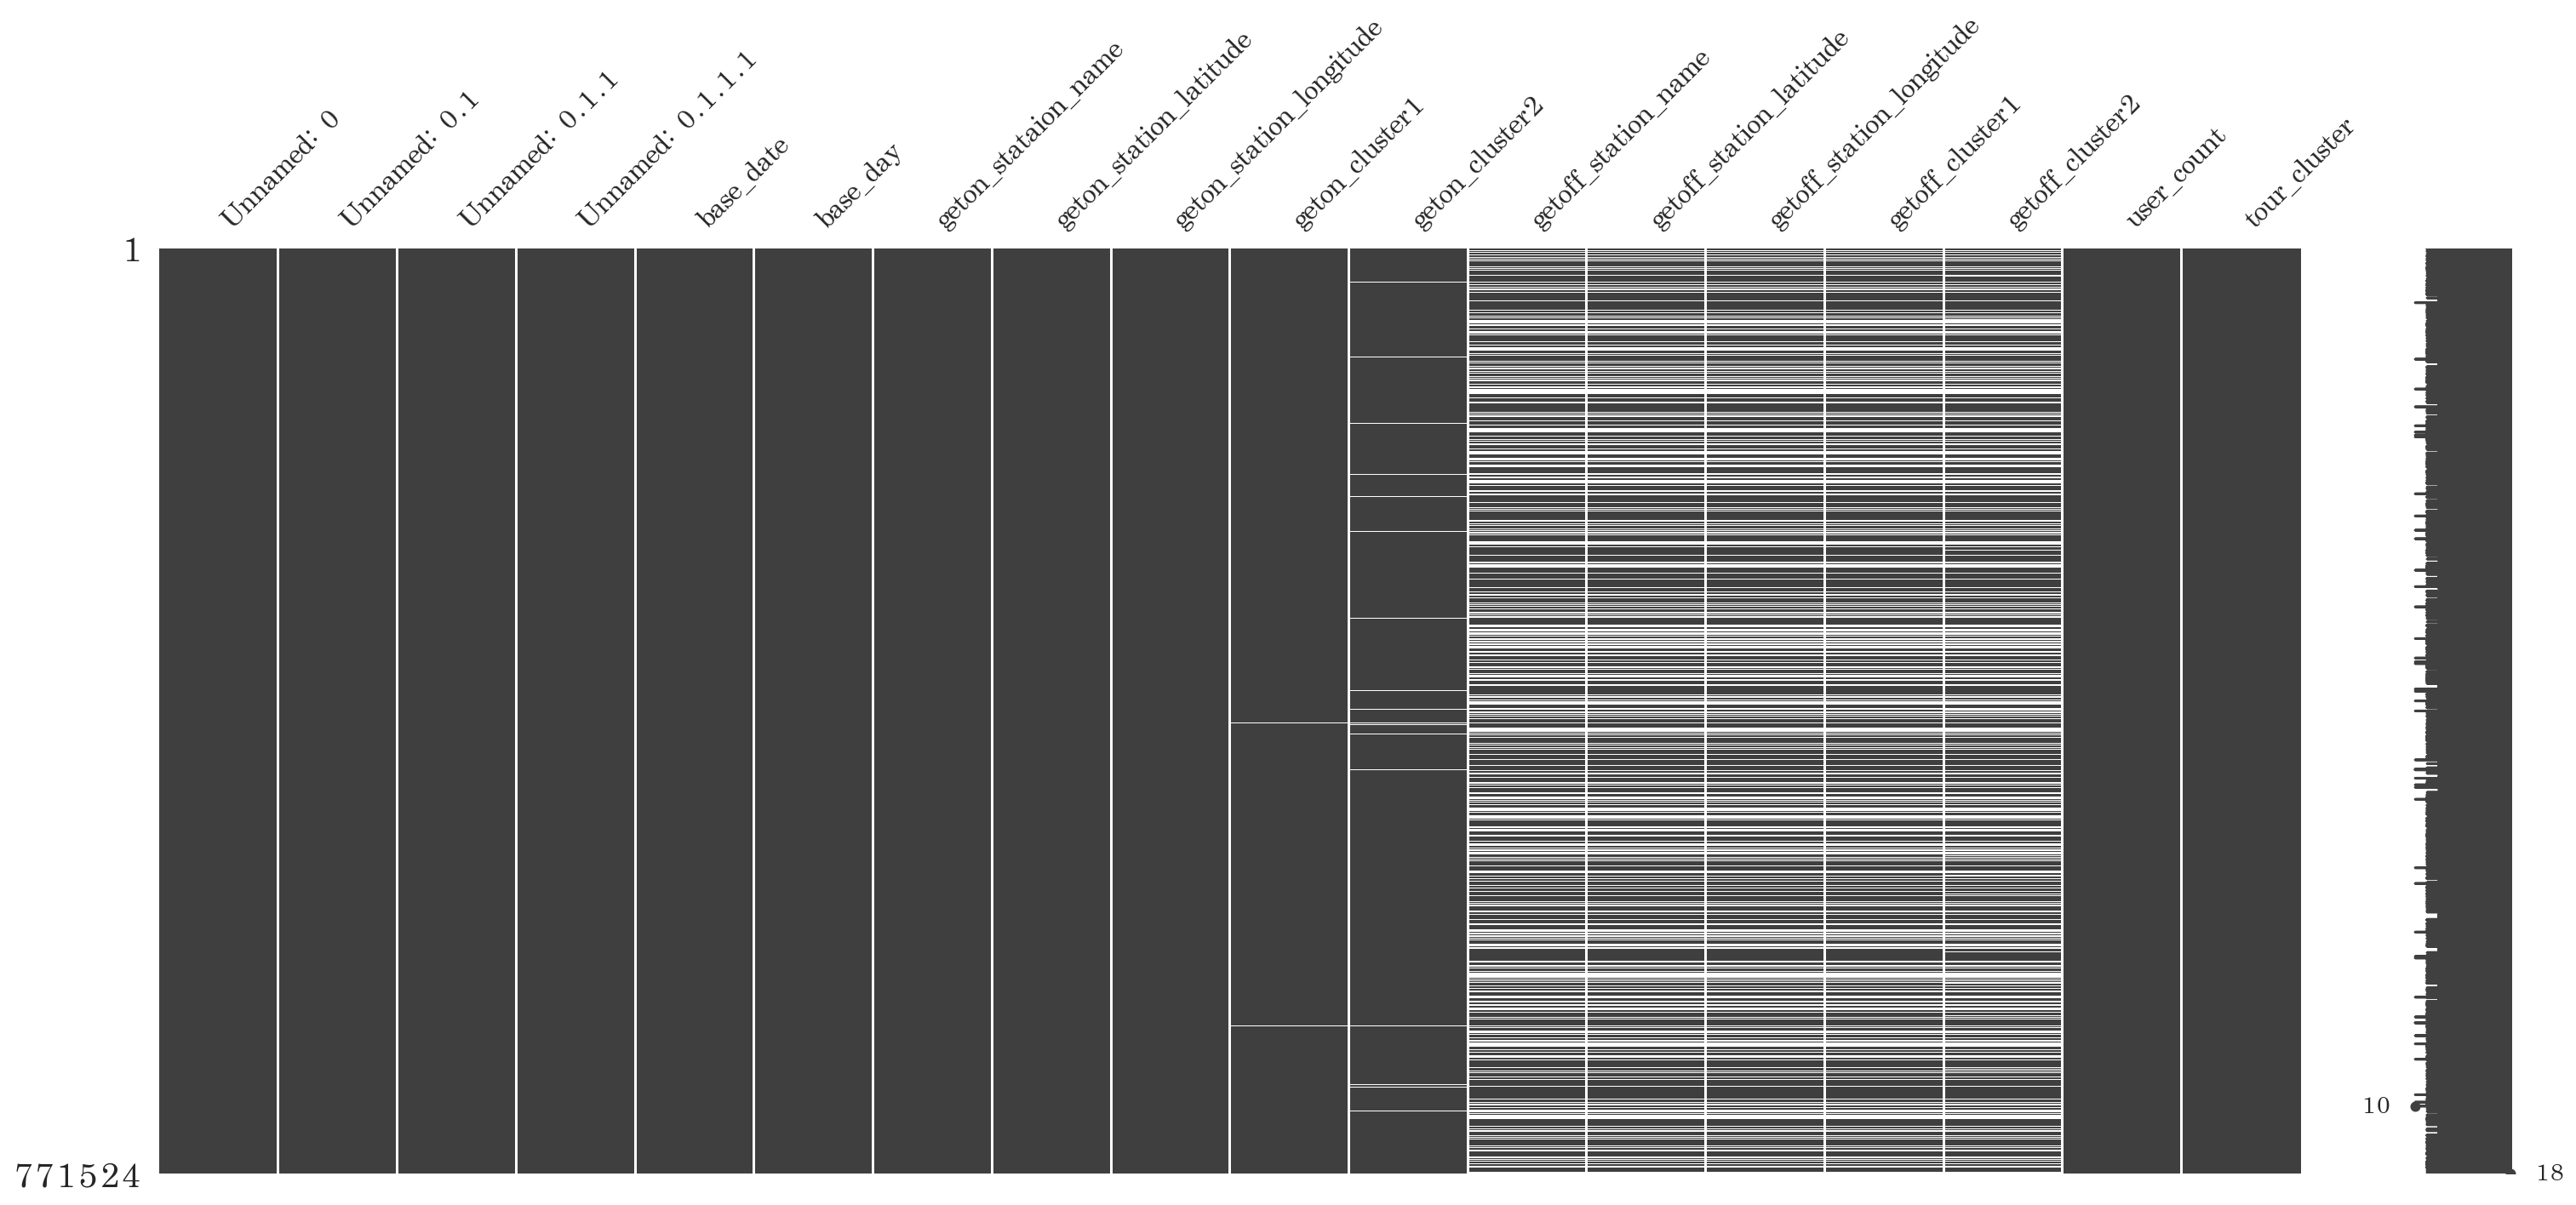

In [61]:
msno.matrix(dask_bus)

- 결측값 개수

In [62]:
print(dask_bus.isnull().sum())

Unnamed: 0                       0
Unnamed: 0.1                     0
Unnamed: 0.1.1                   0
Unnamed: 0.1.1.1                 0
base_date                        0
base_day                         0
geton_stataion_name              2
geton_station_latitude           2
geton_station_longitude         47
geton_cluster1                1187
geton_cluster2               14513
getoff_station_name         278606
getoff_station_latitude     278606
getoff_station_longitude    278606
getoff_cluster1             278567
getoff_cluster2             287099
user_count                       0
tour_cluster                     0
dtype: int64


#### 추가 전처리 _  주중/주말 나눠주기

In [63]:
weekly = ['mon', 'tue', 'wed', 'thu']

In [64]:
day_week = []
for idx in list(dask_bus['base_day']):
    if idx in weekly:
        day_week.append("weekly")
    else:
        day_week.append("weekend")

In [65]:
dask_bus["week"] = day_week

#### 추가 전처리 _관광지 지역 분류해주기

In [66]:
북 = ['용담해안도로', '구제주_탑동']
동북 = ['함덕', '김녕', '월정', '세화']
동남 = ['성산일출봉_섭지코지', '표선해수욕장']
남 = ['남원', '위미', '서귀포시_법환포구', '중문']
서남 = ['사계', '모슬포', '차귀', '신창']
서북 = ['판포', '협재', '한림', '곽지', '애월']
서부_중산간 = ['안덕_중산간', '안덕_동서광']
동부_중산간 = ['남조로', '성산_중산간']

cluster_tour = [북, 동북, 동남, 남, 서남, 서북, 서부_중산간, 동부_중산간]
cluster_tour_name = ['북', '동북', '동남', '남', '서남', '서북', '서부_중산간', '동부_중산간']

In [67]:
# 관광지 클러스터 함수
def cluster3(cluster_name):
    for num, i in enumerate(cluster_tour):
        if cluster_name in i:
            return cluster_tour_name[num]

In [68]:
dask_bus["tour_cluster_on"] = dask_bus["geton_cluster1"].apply(lambda x : cluster3(x))
dask_bus["tour_cluster_off"] = dask_bus["getoff_cluster1"].apply(lambda x : cluster3(x))

In [69]:
# 비관광지 별도로 채워주기

In [70]:
dask_bus["tour_cluster_on"] = dask_bus["tour_cluster_on"].fillna("비관광지")
dask_bus["tour_cluster_off"] = dask_bus["tour_cluster_off"].fillna("비관광지")

In [76]:
# Unnamed 컬럼 drop

In [75]:
dask_bus = dask_bus.drop(["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1"], axis=1)

#### 바그래프로 요일별 이용객수 확인하기
- cluster2, tour_cluster 로 분류

In [78]:
# cluster2 기준의 요일별 승차 현황
geton_cluster2 = dask_bus[["geton_cluster2", "base_day", "week", "user_count"]].groupby(['geton_cluster2', "base_day", "week"]).sum().reset_index().sort_values("user_count", ascending=False)

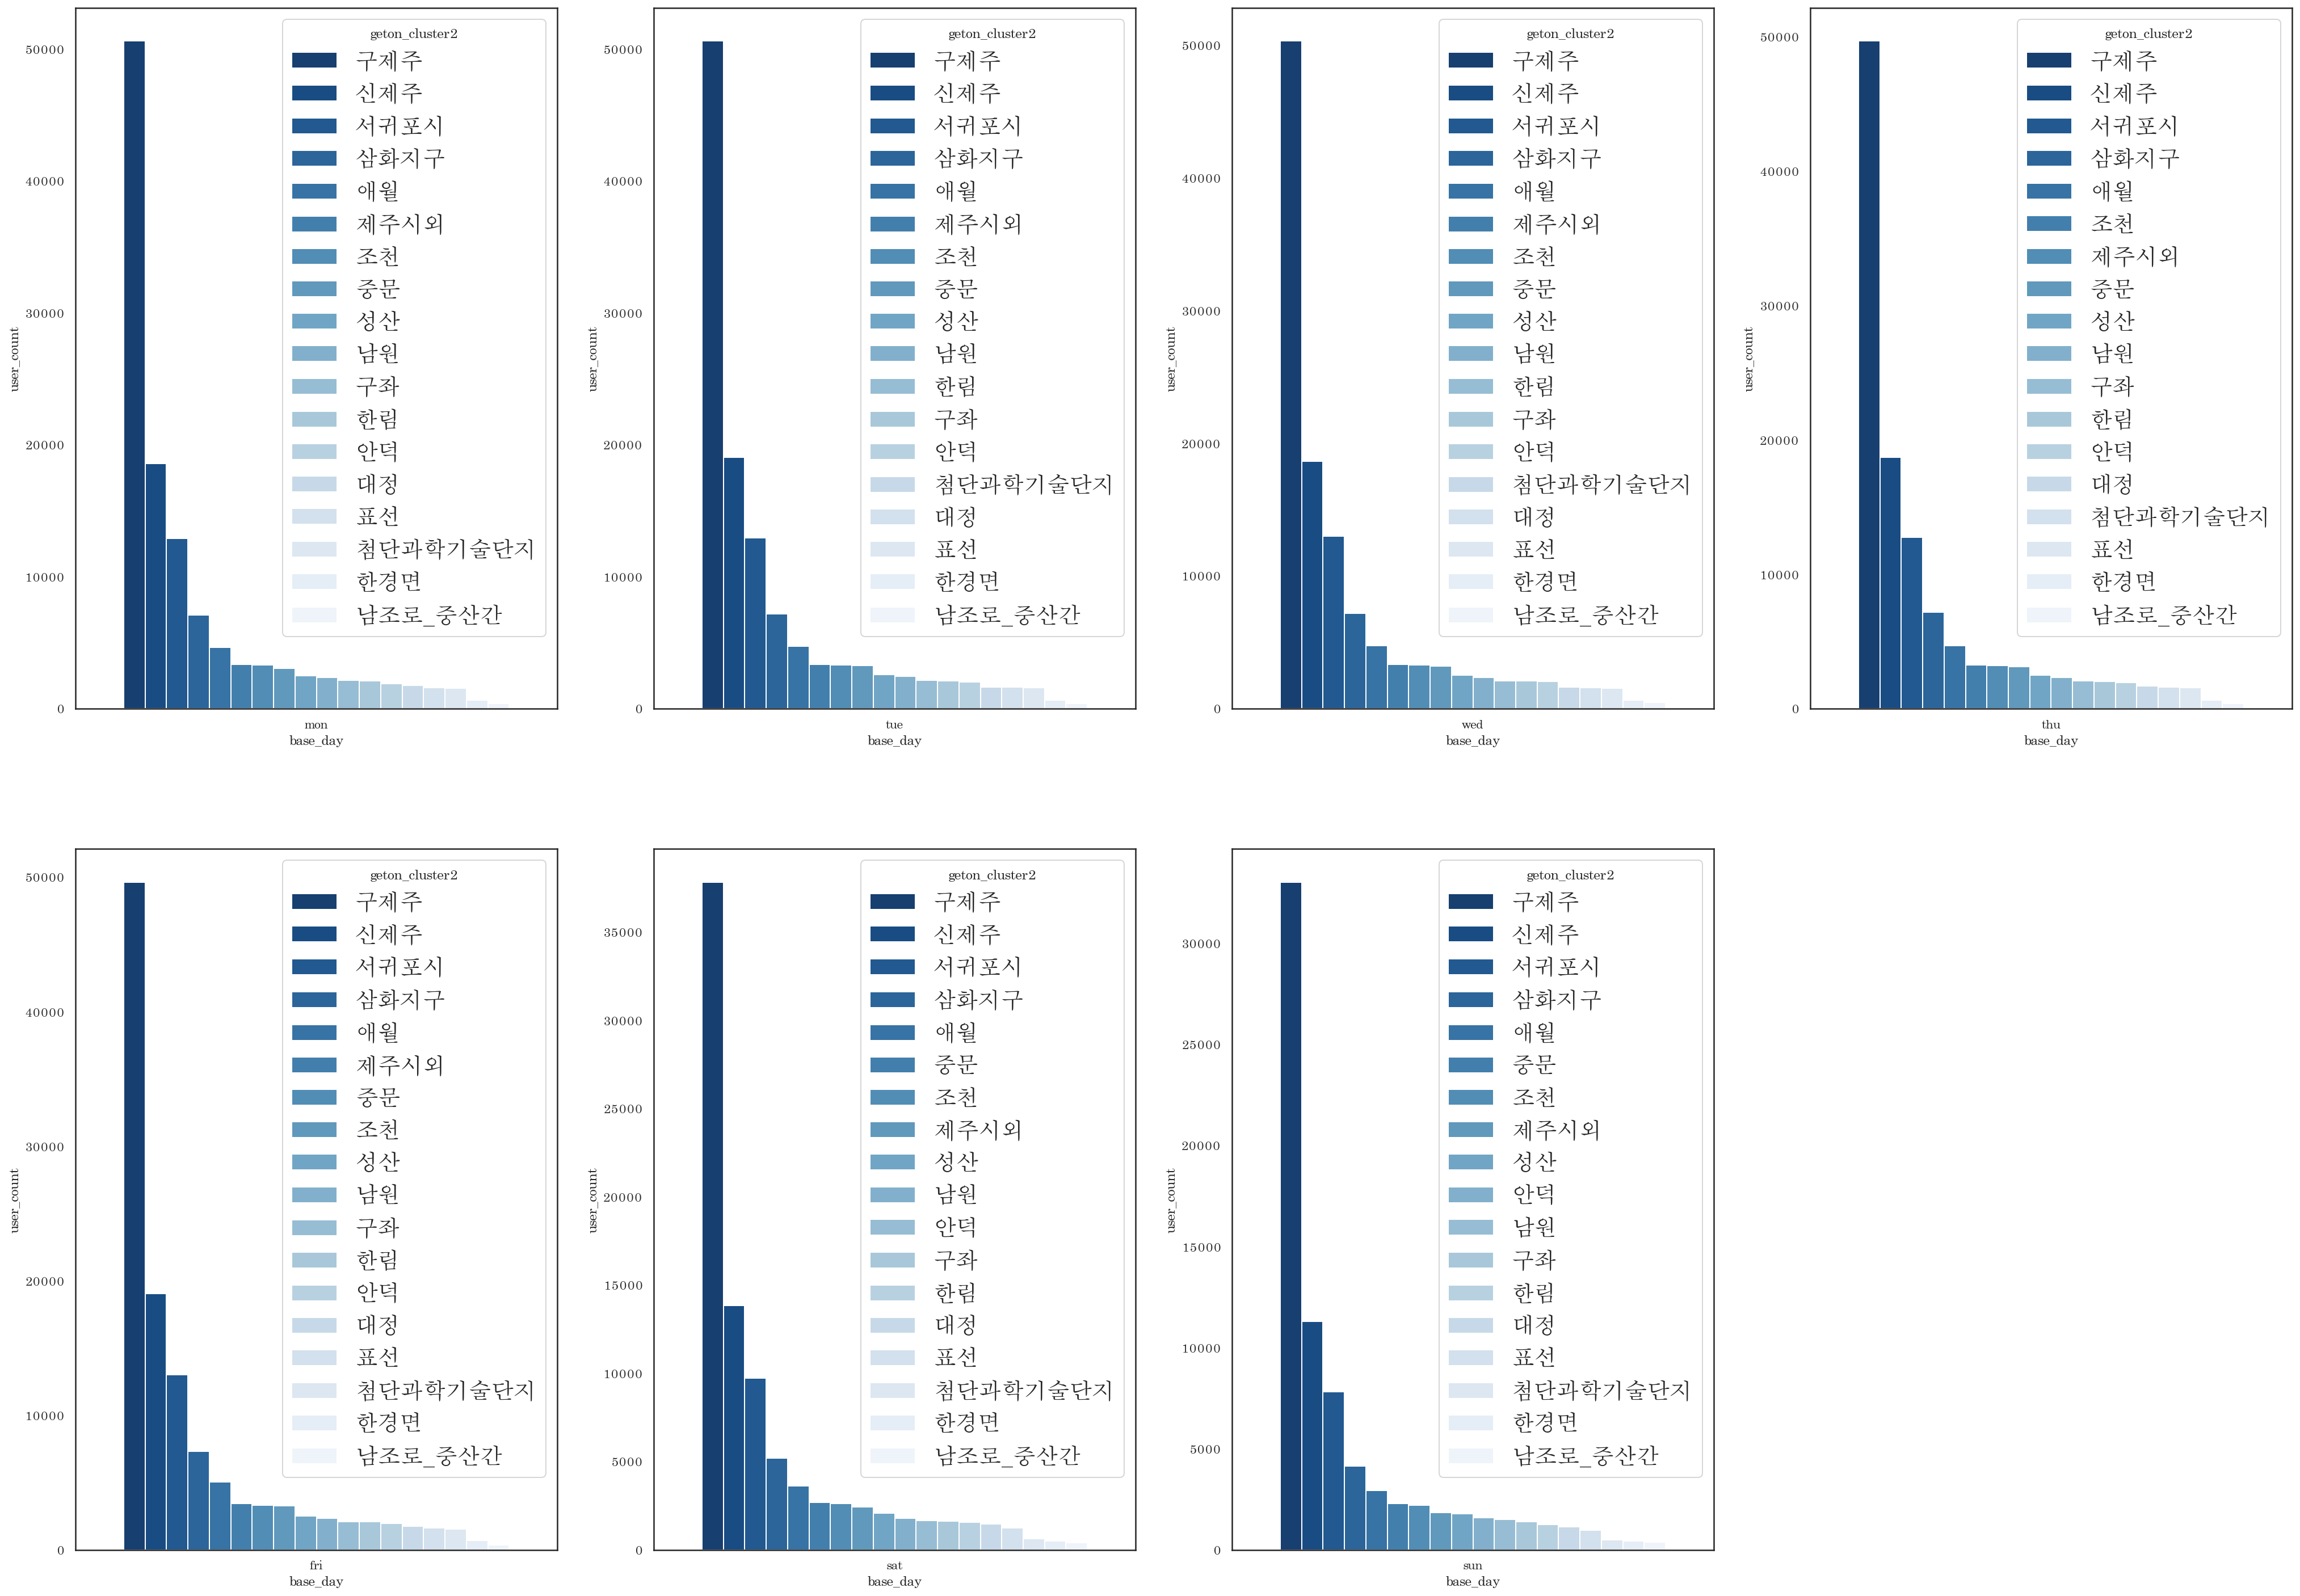

In [82]:
plt.figure(figsize=(35,25))
plt.rc('legend', fontsize=20)

plt.subplot(241)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "mon"], hue="geton_cluster2", palette='Blues_r')
plt.subplot(242)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "tue"], hue="geton_cluster2", palette='Blues_r')
plt.subplot(243)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "wed"], hue="geton_cluster2", palette='Blues_r')
plt.subplot(244)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "thu"], hue="geton_cluster2", palette='Blues_r')
plt.subplot(245)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "fri"], hue="geton_cluster2", palette='Blues_r')
plt.subplot(246)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "sat"], hue="geton_cluster2", palette='Blues_r')
plt.subplot(247)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2[geton_cluster2["base_day"] == "sun"], hue="geton_cluster2", palette='Blues_r')

plt.show();

In [84]:
# 도심지역의 요일별 승차 현황
geton_cluster2_city = geton_cluster2[(geton_cluster2["geton_cluster2"] == "구제주") | (geton_cluster2["geton_cluster2"] == "신제주") | (geton_cluster2["geton_cluster2"] == "서귀포시") | (geton_cluster2["geton_cluster2"] == "삼화지구")]

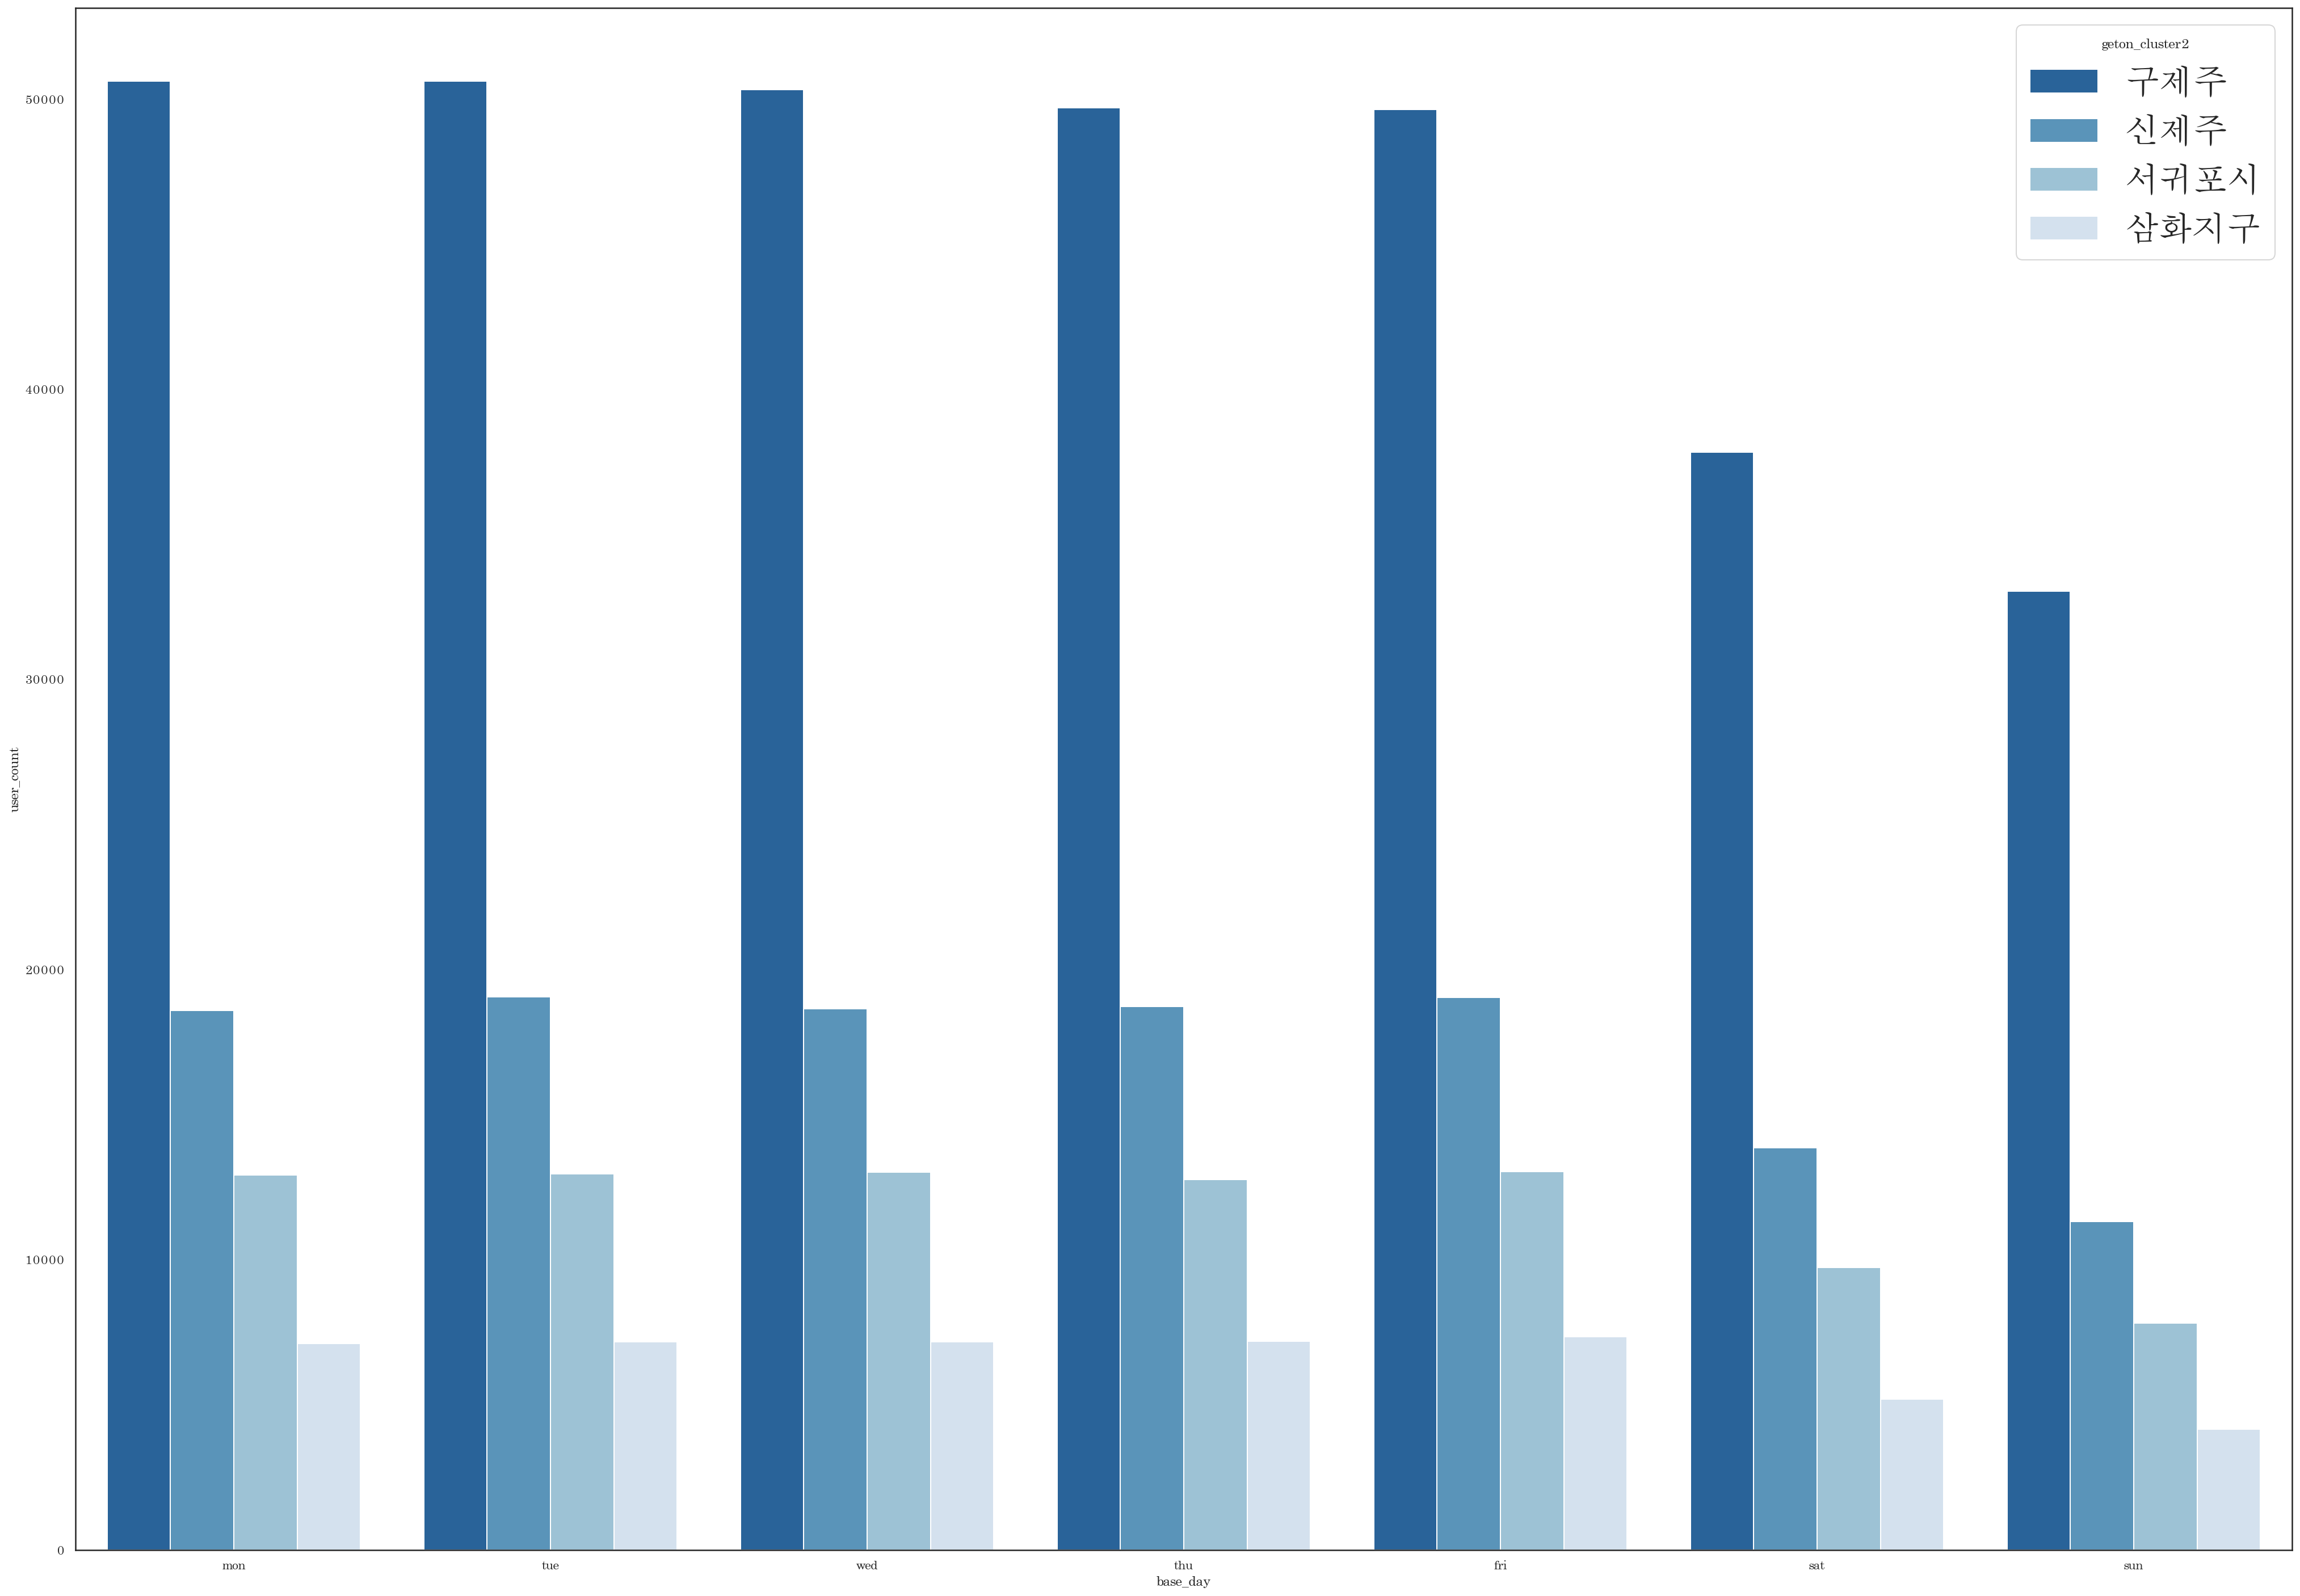

In [85]:
plt.figure(figsize=(35,25))
plt.rc('legend', fontsize=30)
sns.barplot(x="base_day", y="user_count", data=geton_cluster2_city, hue="geton_cluster2", palette='Blues_r')
plt.show();

In [86]:
# tour_cluster 기준의 요일별 승차 현황
geton_tour_cluster = dask_bus[["tour_cluster_on", "base_day", "week", "user_count"]].groupby(['tour_cluster_on', "base_day", "week"]).sum().reset_index().sort_values("user_count", ascending=False)

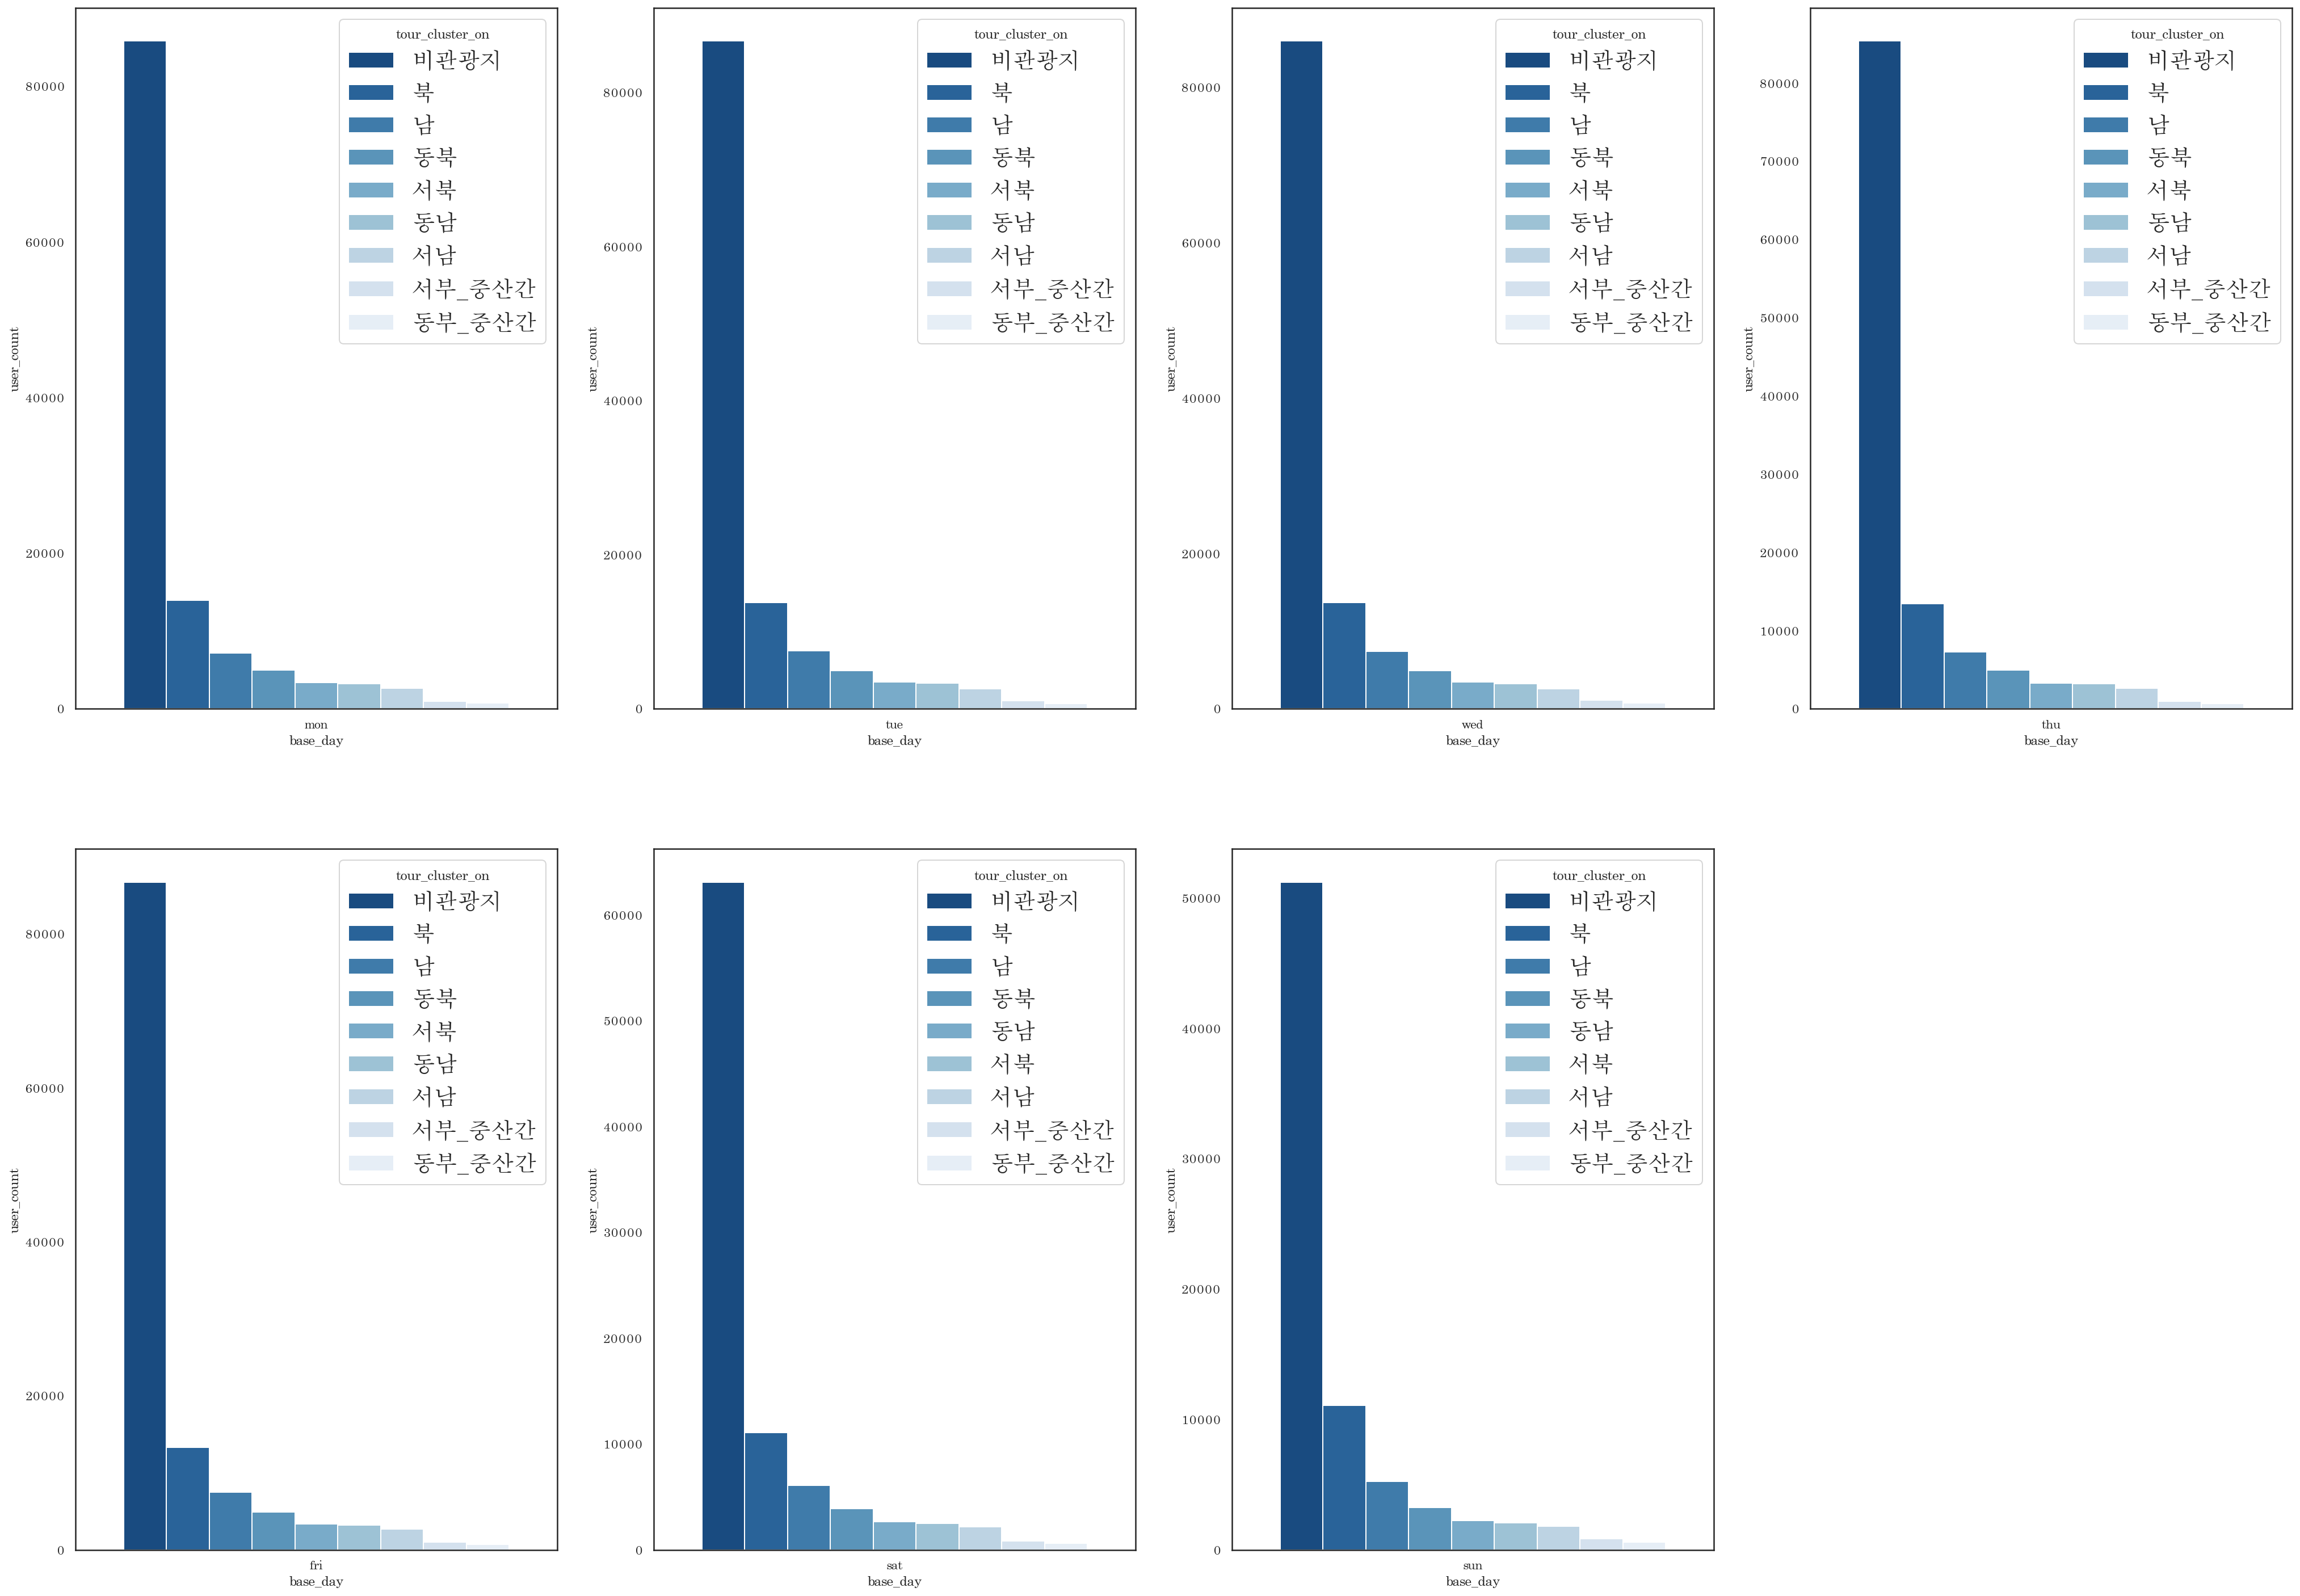

In [87]:
plt.figure(figsize=(35,25))
plt.rc('legend', fontsize=20)

plt.subplot(241)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "mon"], hue="tour_cluster_on", palette='Blues_r')
plt.subplot(242)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "tue"], hue="tour_cluster_on", palette='Blues_r')
plt.subplot(243)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "wed"], hue="tour_cluster_on", palette='Blues_r')
plt.subplot(244)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "thu"], hue="tour_cluster_on", palette='Blues_r')
plt.subplot(245)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "fri"], hue="tour_cluster_on", palette='Blues_r')
plt.subplot(246)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "sat"], hue="tour_cluster_on", palette='Blues_r')
plt.subplot(247)
sns.barplot(x="base_day", y="user_count", data=geton_tour_cluster[geton_tour_cluster["base_day"] == "sun"], hue="tour_cluster_on", palette='Blues_r')

plt.show();

In [89]:
# cluster2 기준의 요일별 하차 현황
getoff_cluster2 = dask_bus[["getoff_cluster2", "base_day", "week", "user_count"]].groupby(['getoff_cluster2', "base_day", "week"]).sum().reset_index().sort_values("user_count", ascending=False)

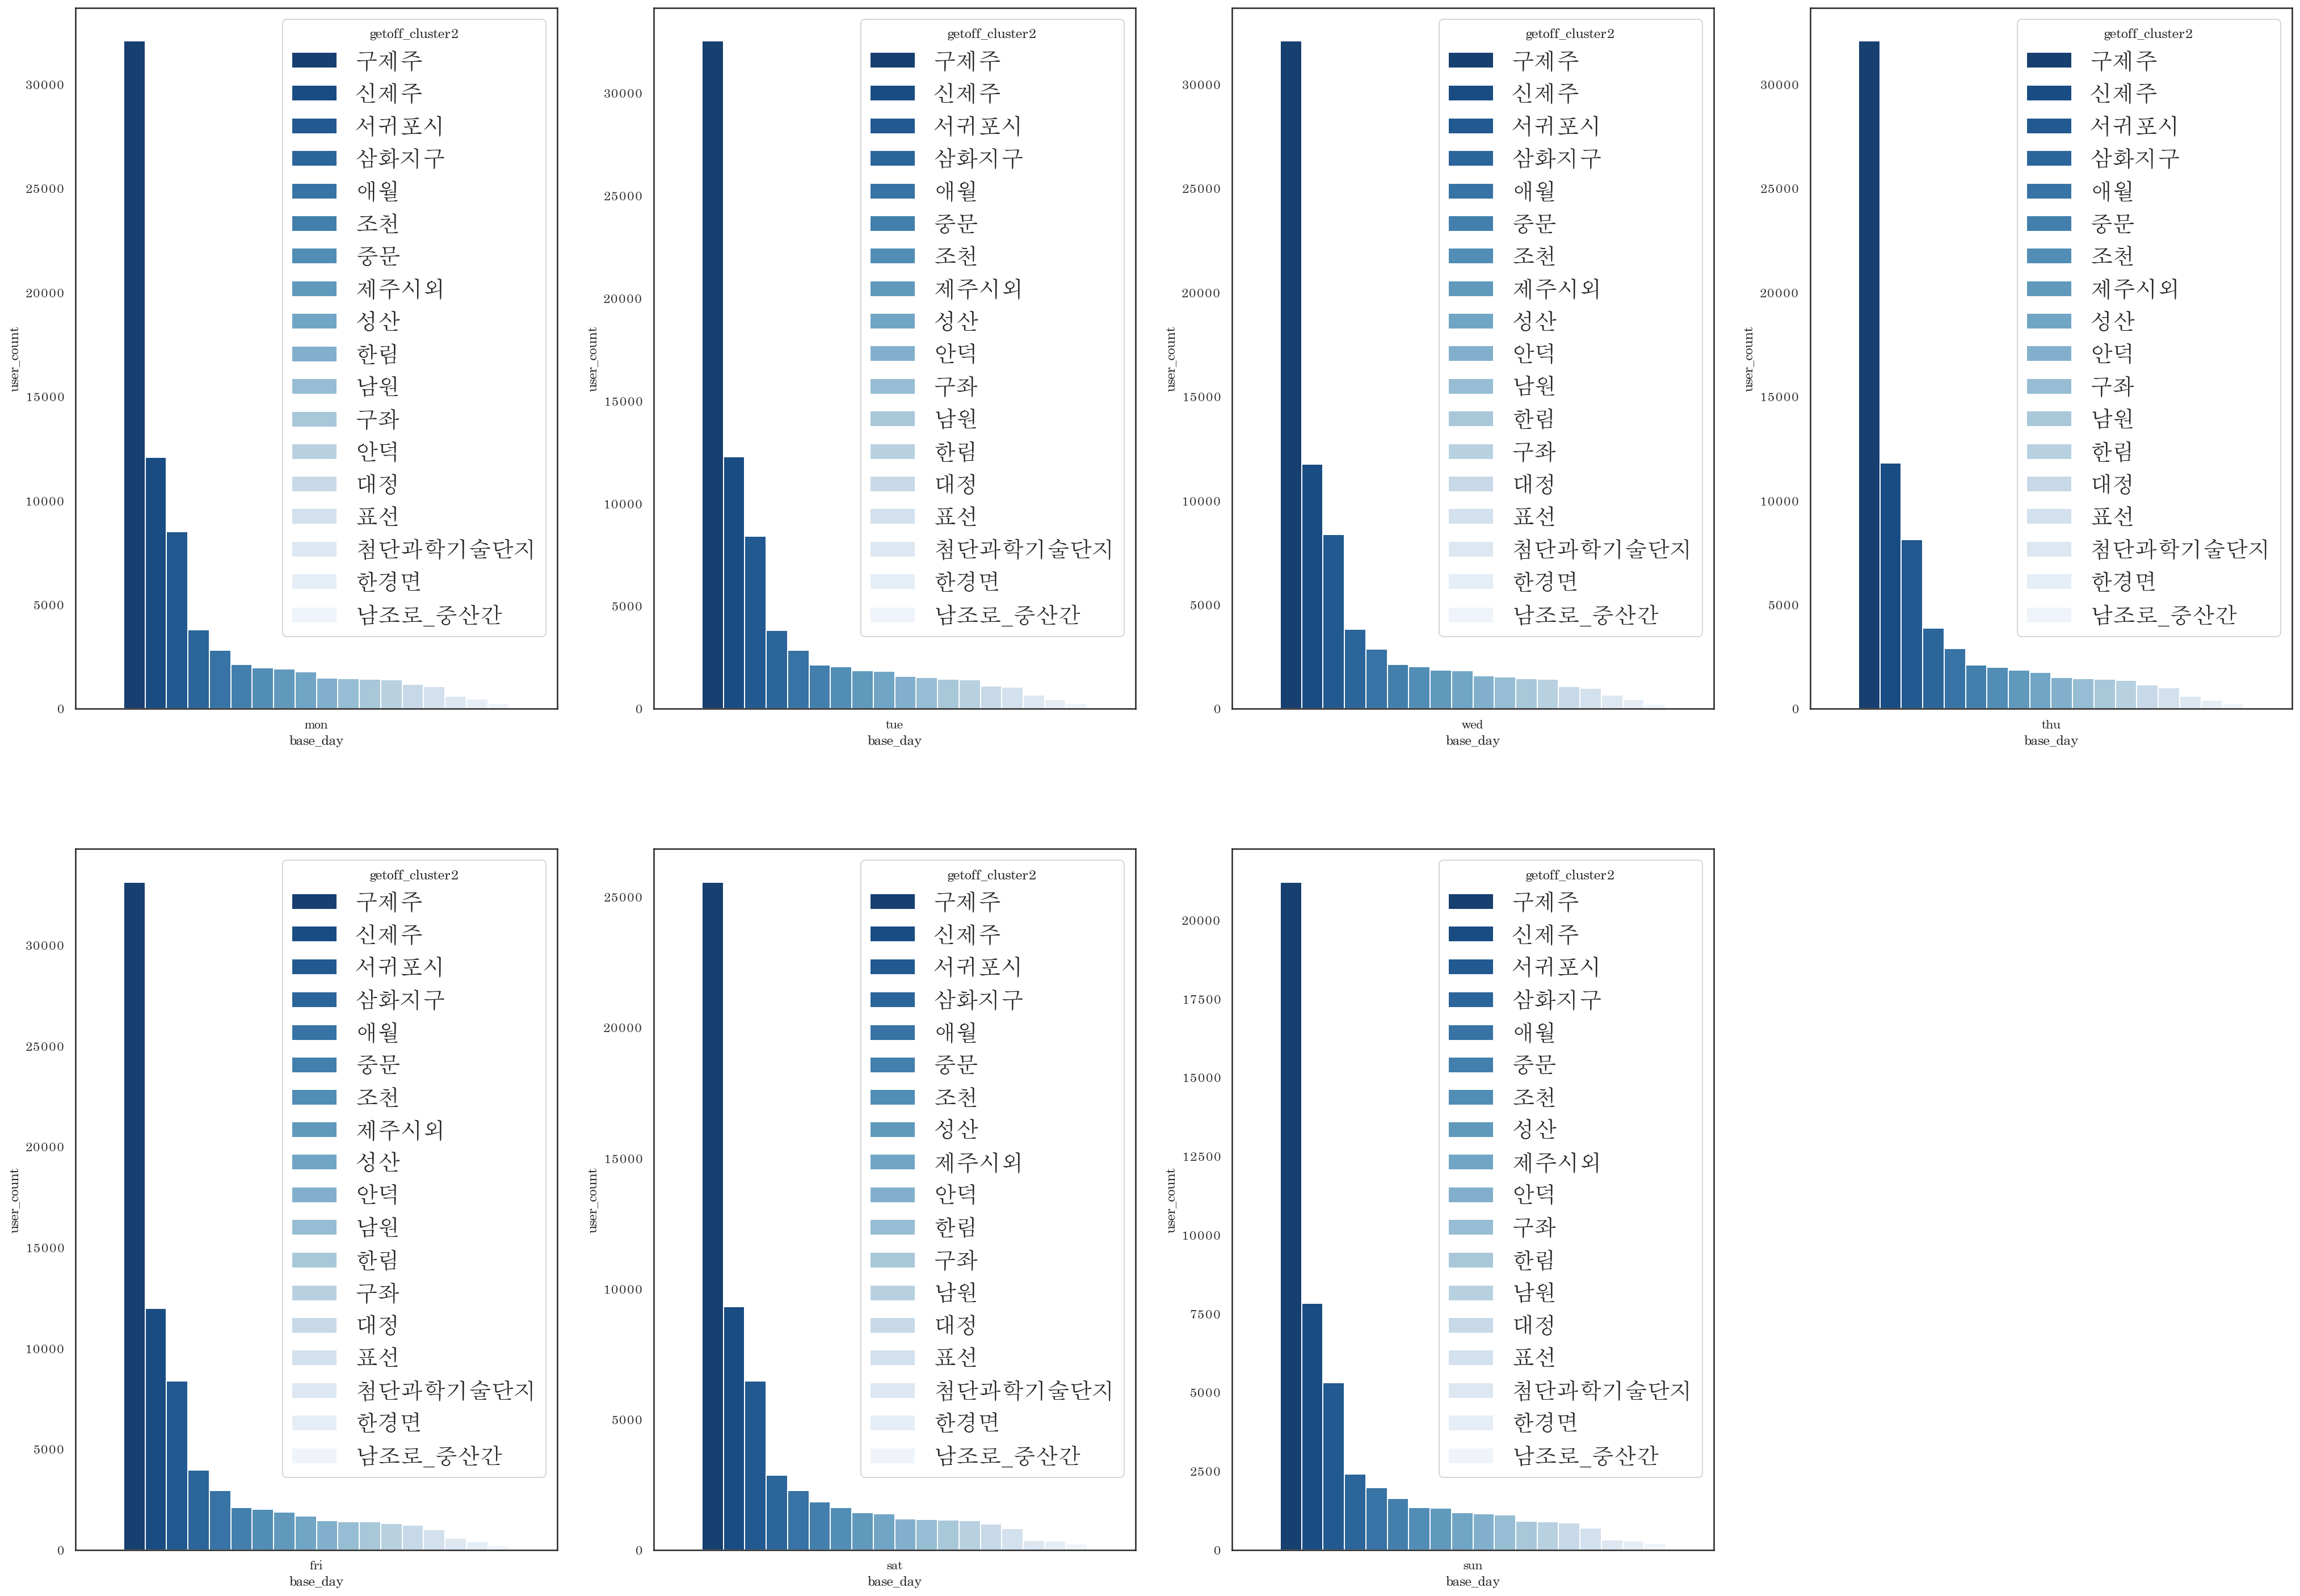

In [90]:
plt.figure(figsize=(35,25))
plt.rc('legend', fontsize=20)

plt.subplot(241)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "mon"], hue="getoff_cluster2", palette='Blues_r')
plt.subplot(242)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "tue"], hue="getoff_cluster2", palette='Blues_r')
plt.subplot(243)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "wed"], hue="getoff_cluster2", palette='Blues_r')
plt.subplot(244)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "thu"], hue="getoff_cluster2", palette='Blues_r')
plt.subplot(245)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "fri"], hue="getoff_cluster2", palette='Blues_r')
plt.subplot(246)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "sat"], hue="getoff_cluster2", palette='Blues_r')
plt.subplot(247)
sns.barplot(x="base_day", y="user_count", data=getoff_cluster2[getoff_cluster2["base_day"] == "sun"], hue="getoff_cluster2", palette='Blues_r')

plt.show();

In [91]:
# tour_cluster 기준의 요일별 하차 현황
getoff_tour_cluster = dask_bus[["tour_cluster_off", "base_day", "week", "user_count"]].groupby(['tour_cluster_off', "base_day", "week"]).sum().reset_index().sort_values("user_count", ascending=False)

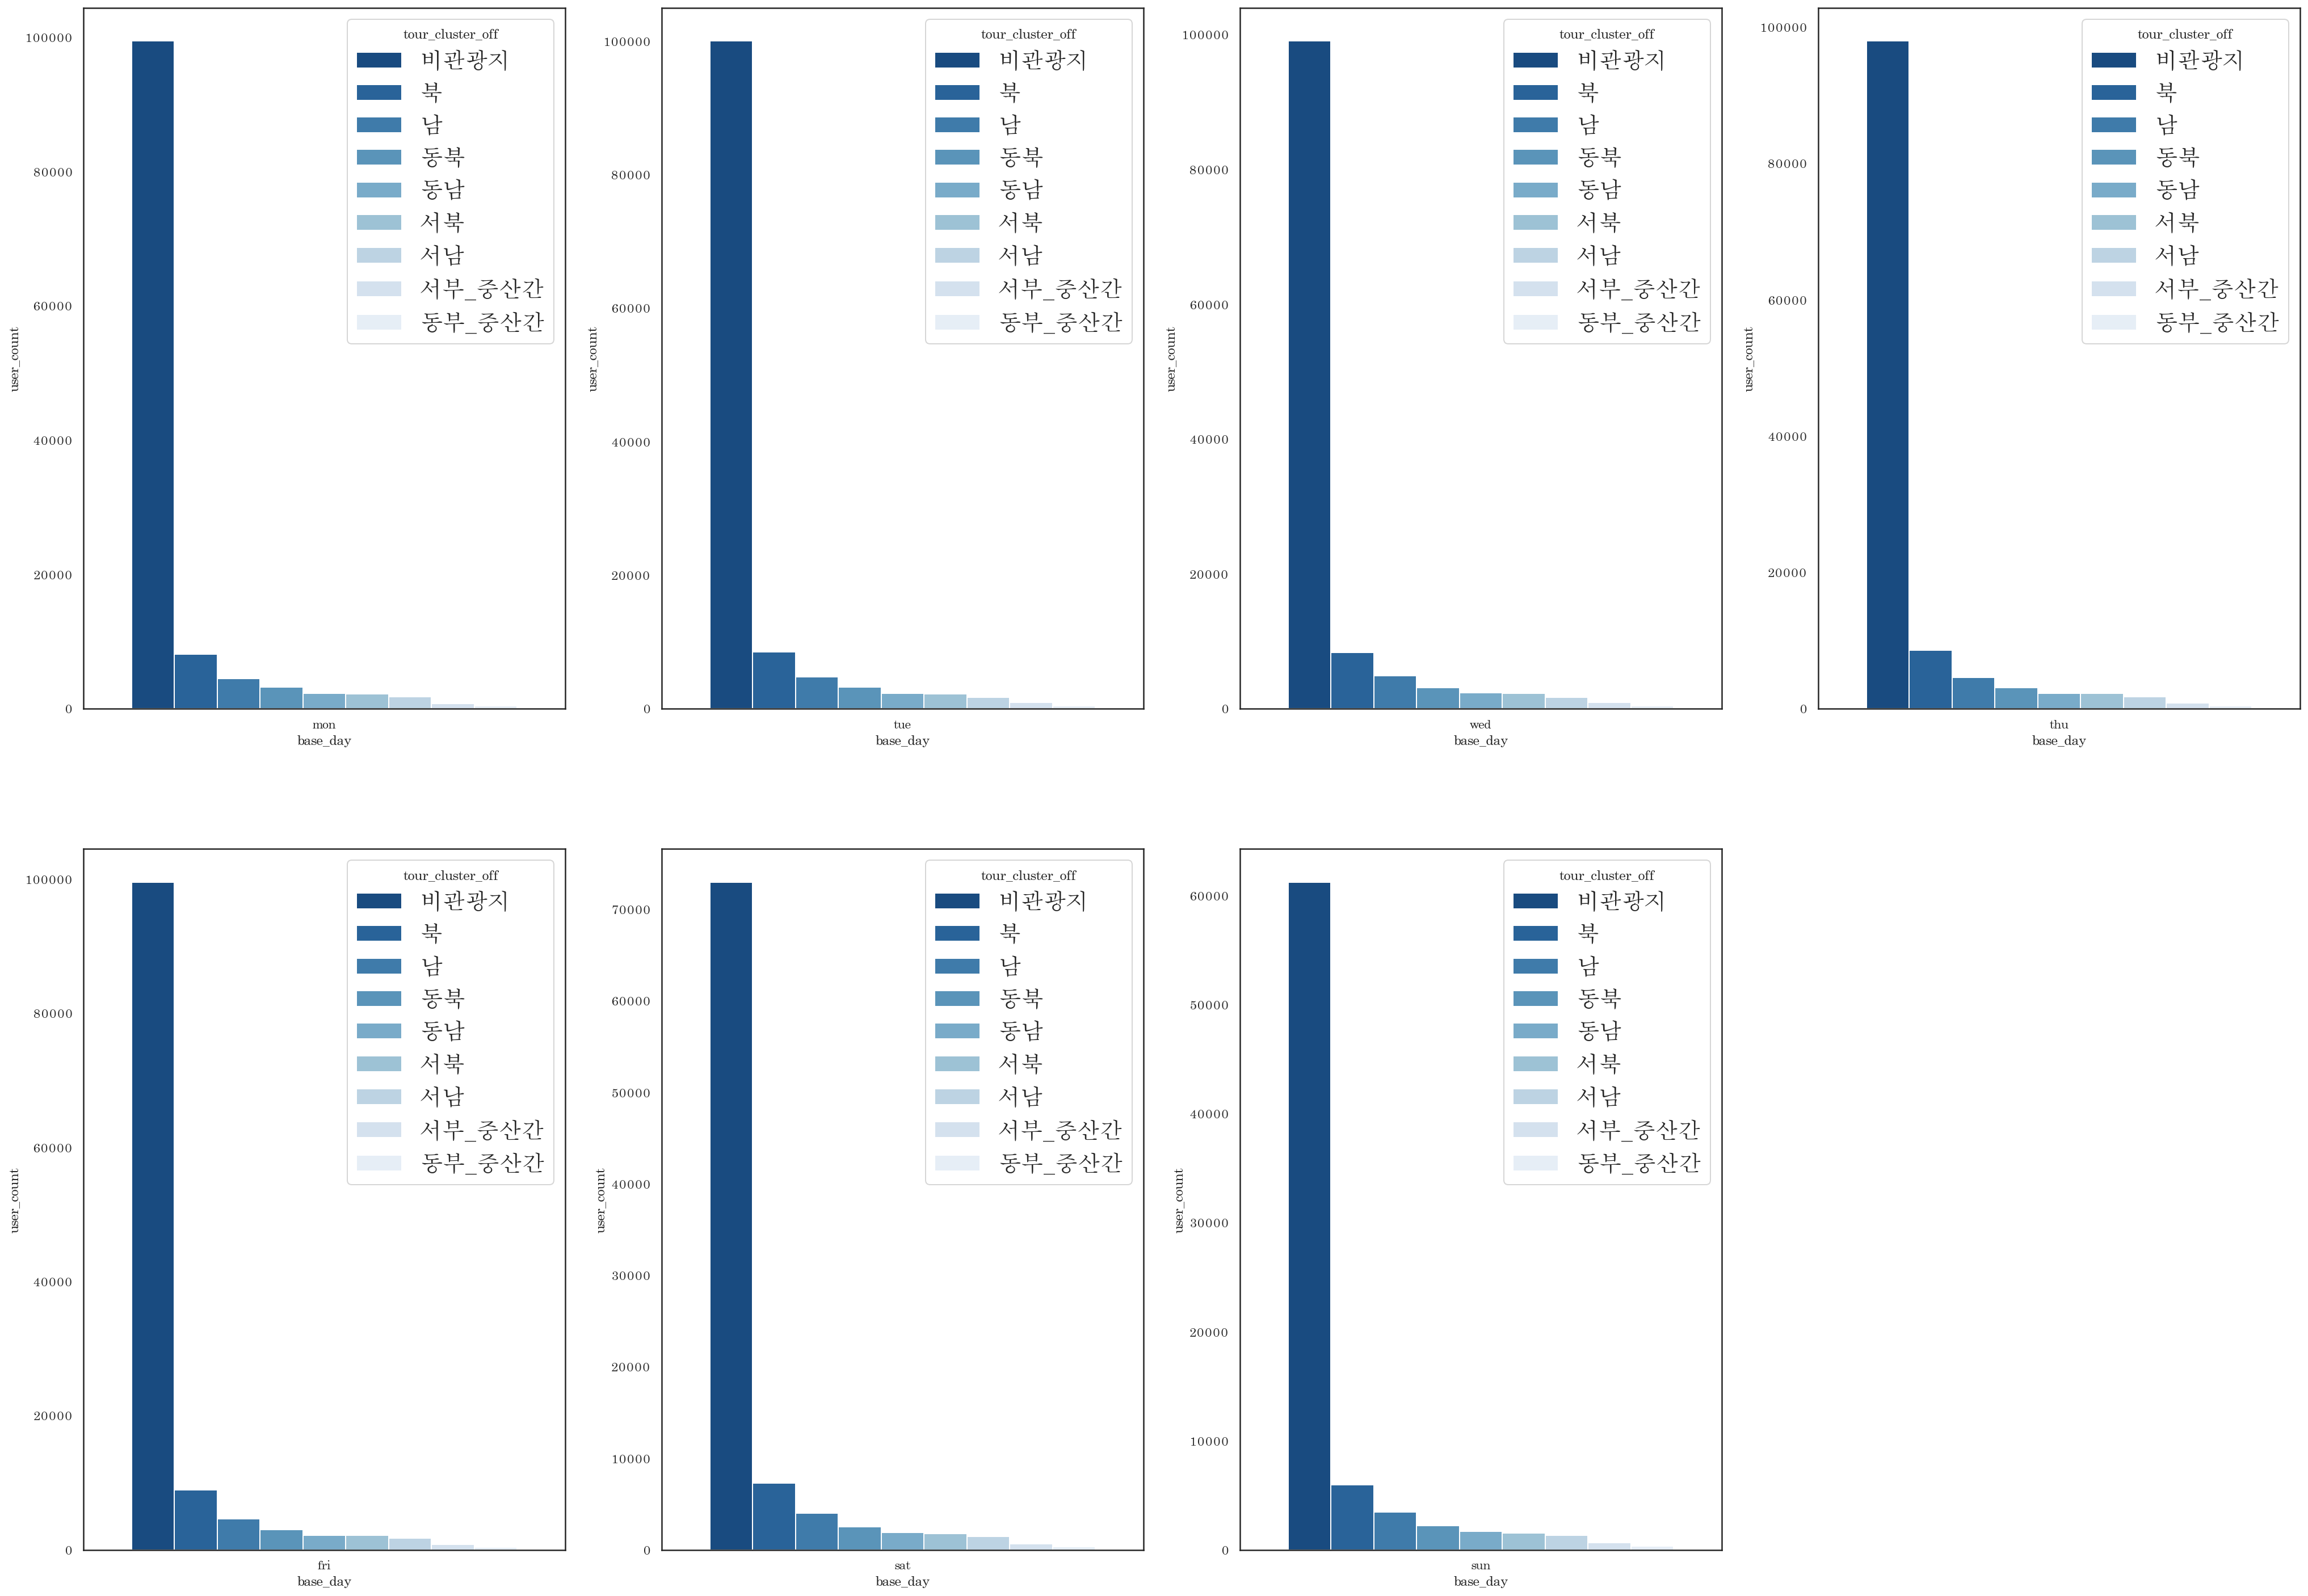

In [92]:
plt.figure(figsize=(35,25))
plt.rc('legend', fontsize=20)

plt.subplot(241)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "mon"], hue="tour_cluster_off", palette='Blues_r')
plt.subplot(242)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "tue"], hue="tour_cluster_off", palette='Blues_r')
plt.subplot(243)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "wed"], hue="tour_cluster_off", palette='Blues_r')
plt.subplot(244)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "thu"], hue="tour_cluster_off", palette='Blues_r')
plt.subplot(245)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "fri"], hue="tour_cluster_off", palette='Blues_r')
plt.subplot(246)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "sat"], hue="tour_cluster_off", palette='Blues_r')
plt.subplot(247)
sns.barplot(x="base_day", y="user_count", data=getoff_tour_cluster[getoff_tour_cluster["base_day"] == "sun"], hue="tour_cluster_off", palette='Blues_r')

plt.show();

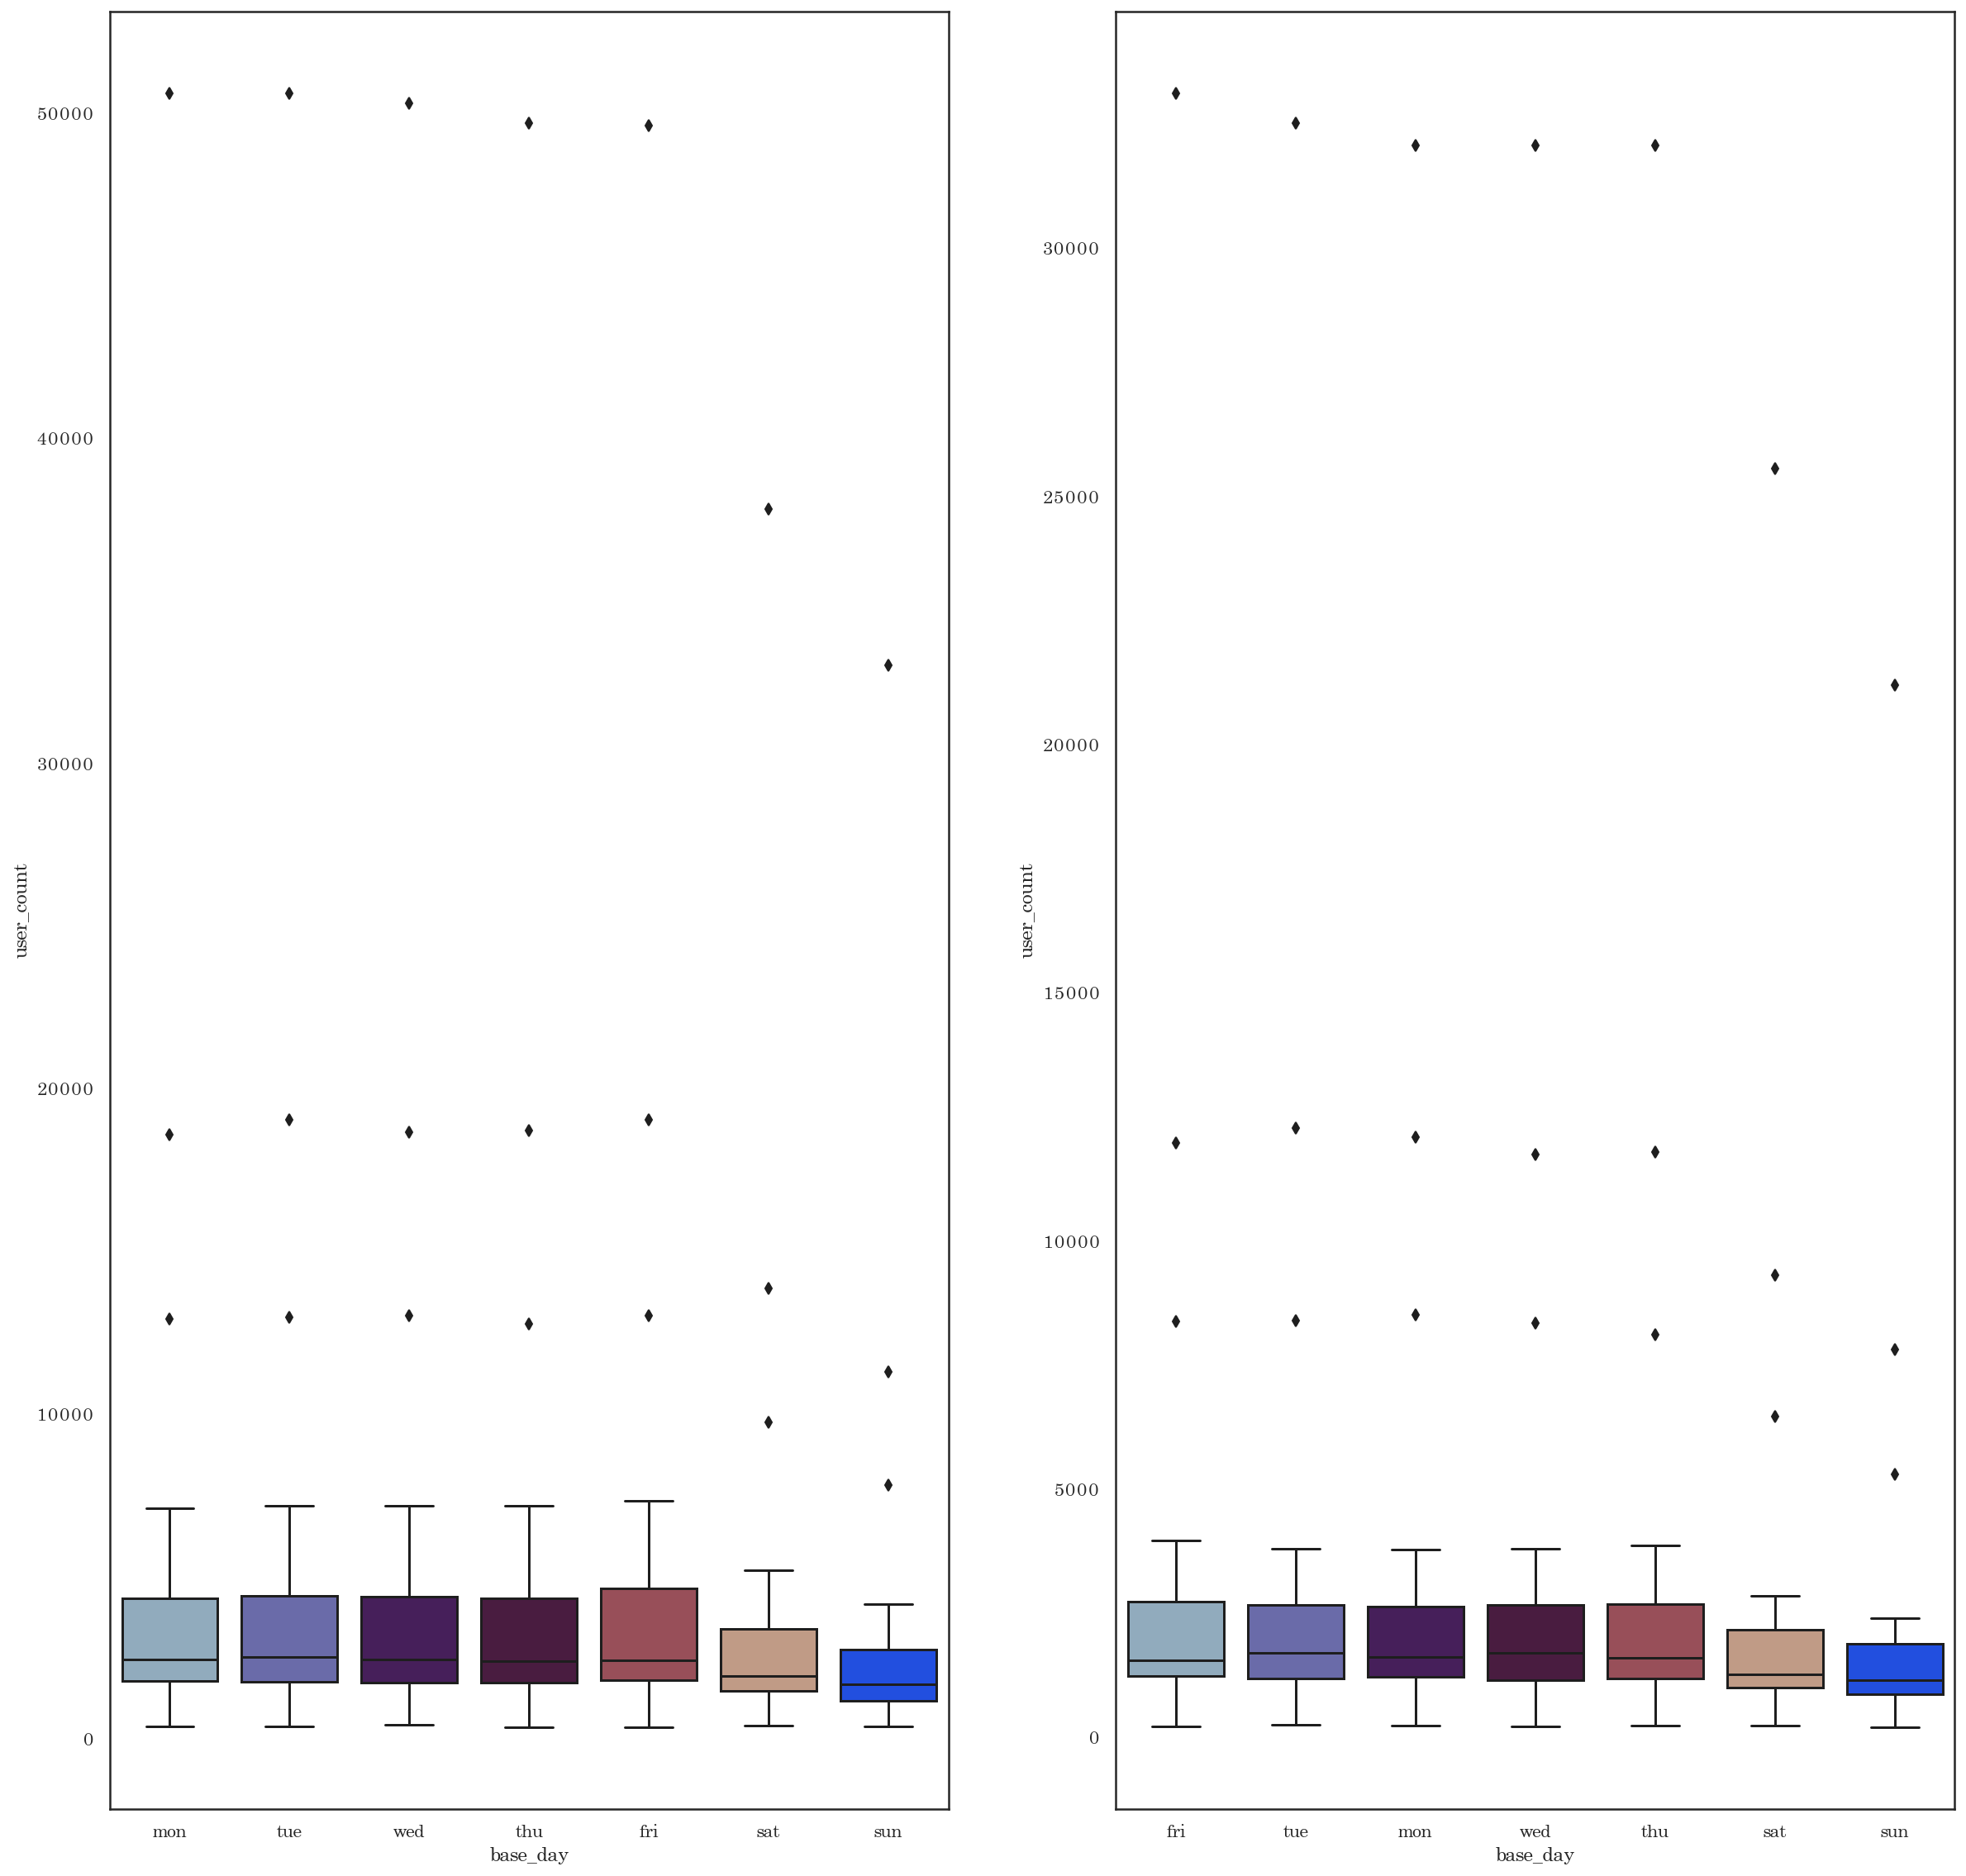

In [97]:
# 요일별 승/하차 이용객 수 비교해보기 _ box plot
plt.figure(figsize=(20, 20))

plt.subplot(121)
sns.boxplot(x=geton_cluster2["base_day"], y=geton_cluster2["user_count"], palette=palette)

plt.subplot(122)
sns.boxplot(x=getoff_cluster2["base_day"], y=getoff_cluster2["user_count"], palette=palette)


plt.show()

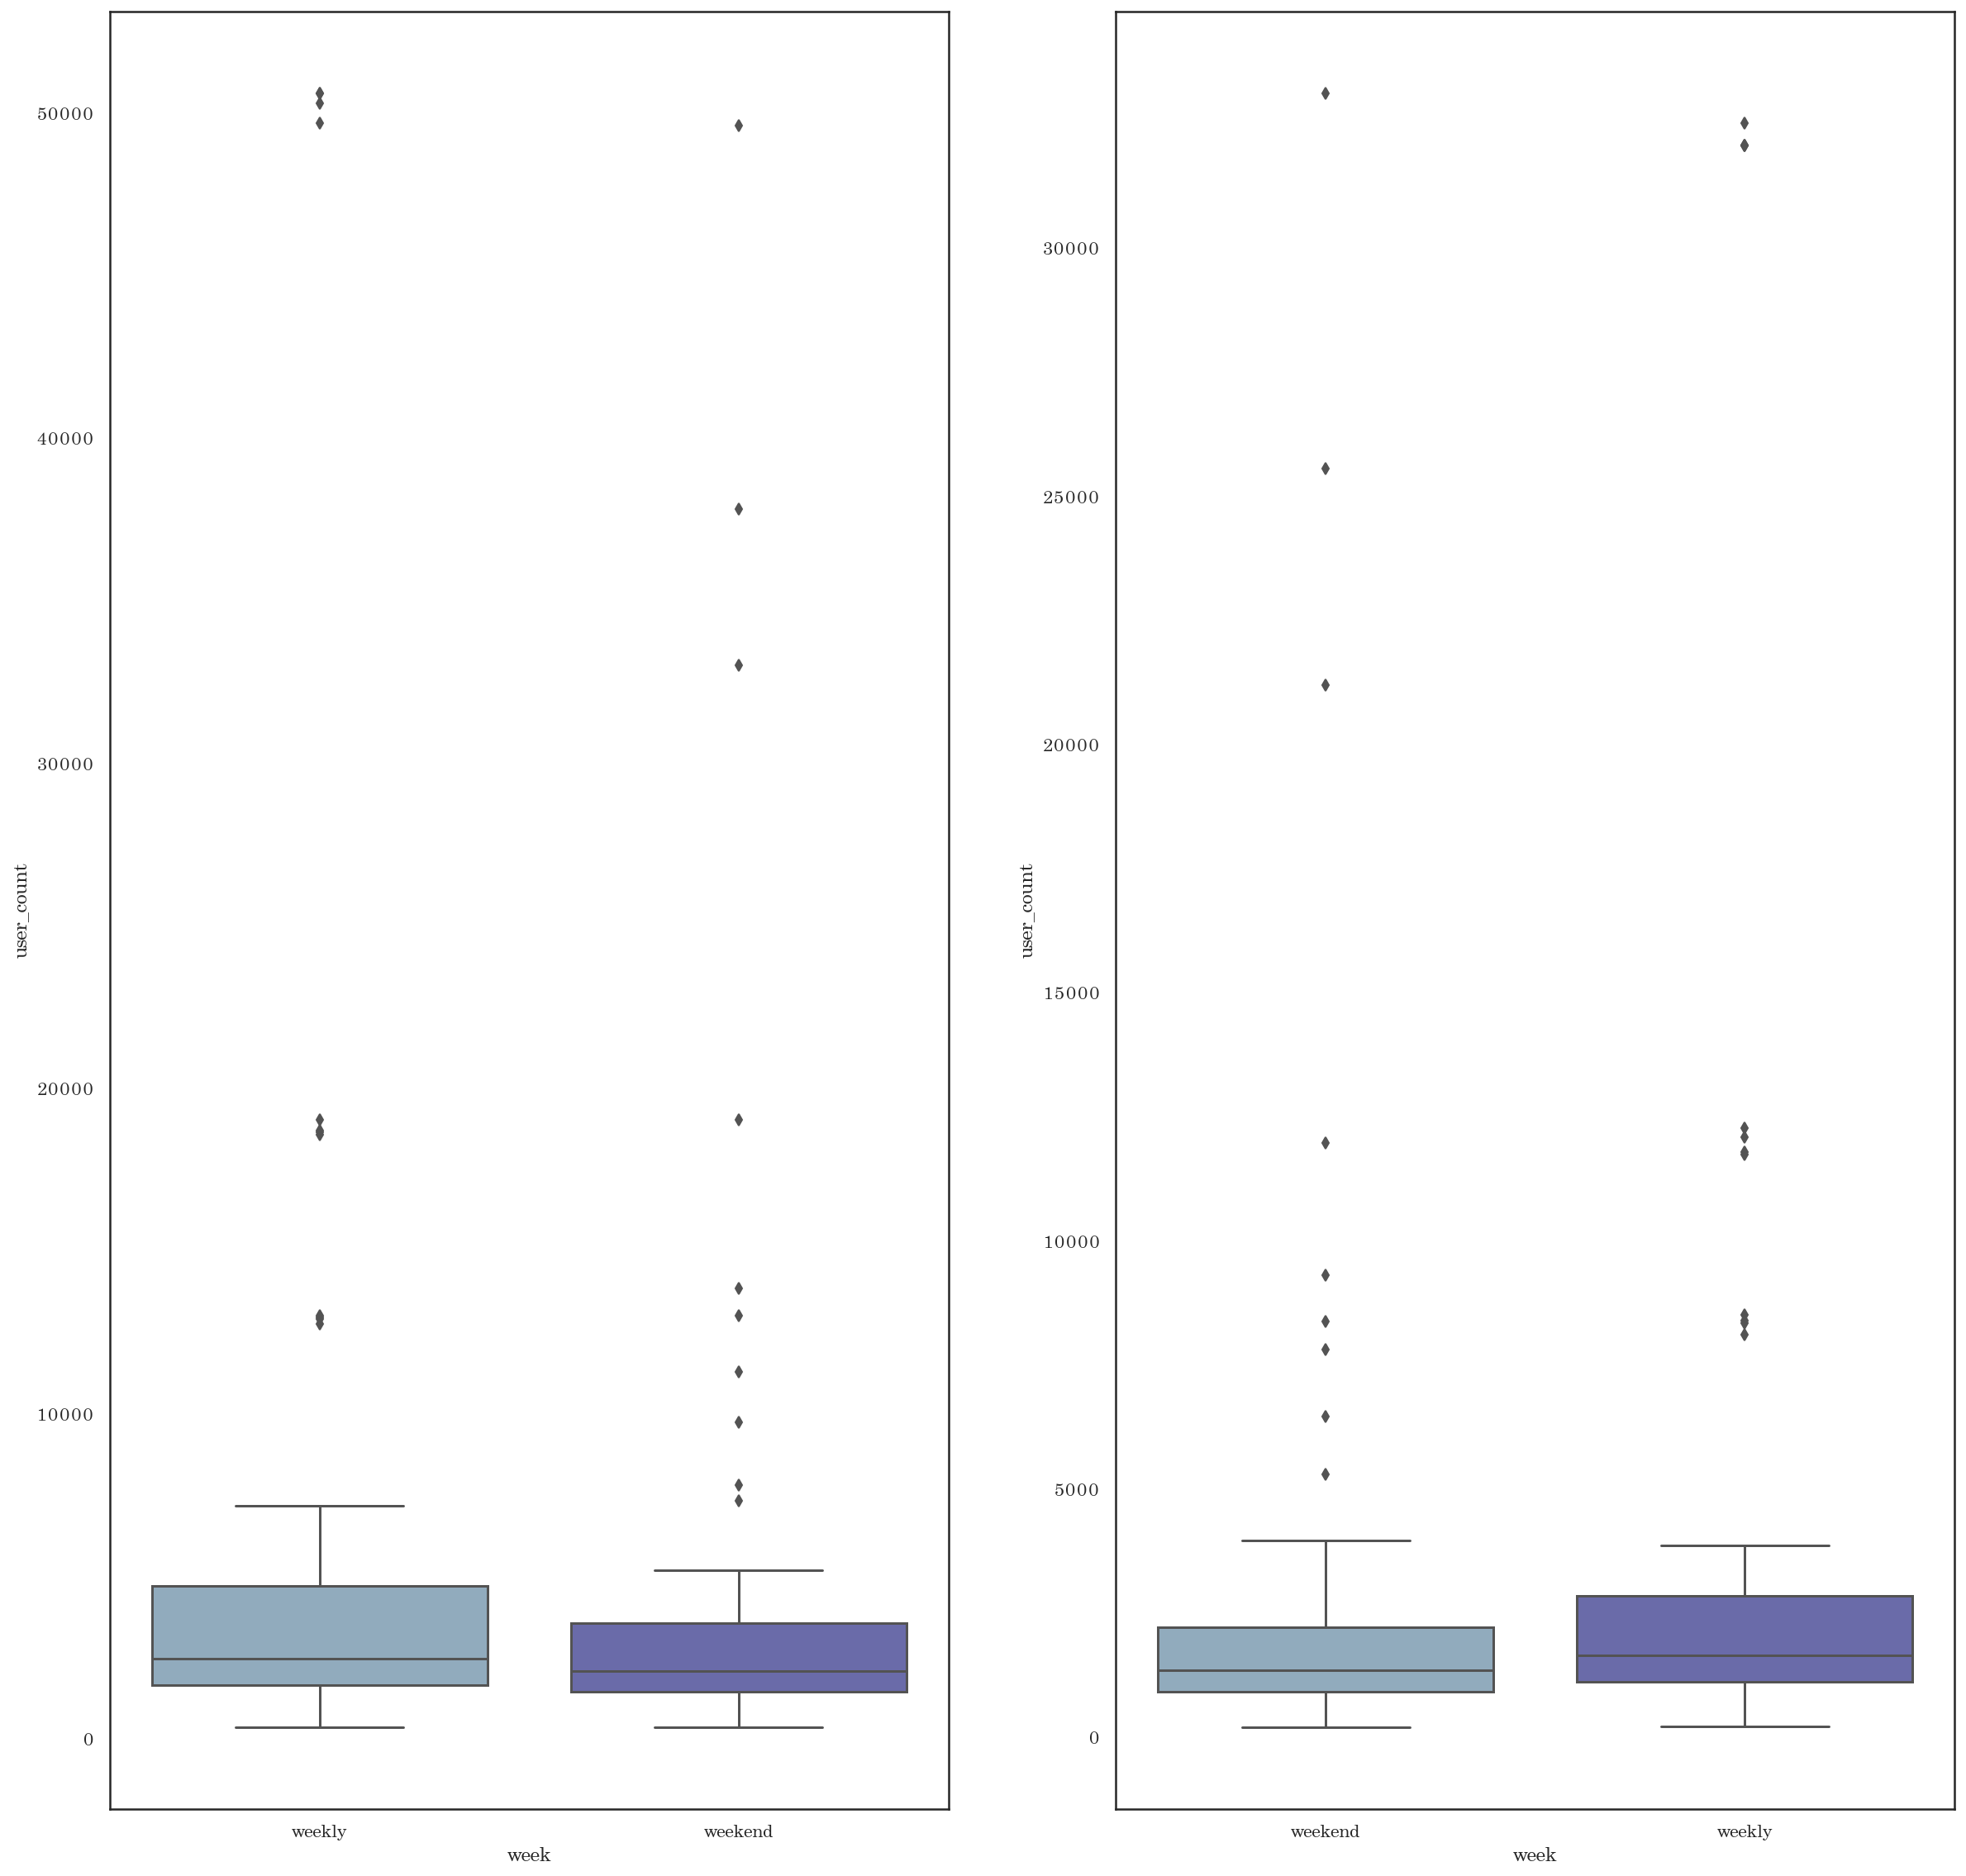

In [98]:
# 주중/주말의 승/하차 이용객 수 비교해보기 _ box plot
plt.figure(figsize=(20, 20))

plt.subplot(121)
sns.boxplot(x=geton_cluster2["week"], y=geton_cluster2["user_count"], palette=palette)

plt.subplot(122)
sns.boxplot(x=getoff_cluster2["week"], y=getoff_cluster2["user_count"], palette=palette)


plt.show()

### 시각화 2
#### folium 사용하여 정류장 표시하기

In [100]:
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

In [104]:
# 해당 주요 장소의 임의 지역 위도, 경도 (baseline 참조)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [105]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data4=dask_bus[['getoff_station_latitude','getoff_station_longitude','getoff_station_name']].drop_duplicates(keep='first')

data5=data4.groupby(['getoff_station_name'])['getoff_station_latitude','getoff_station_longitude'].mean()

data5.to_csv("folium.csv")

data5=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data5.itertuples():
    mc.add_child(folium.Marker(location=[row.getoff_station_latitude,  row.getoff_station_longitude], popup=row.getoff_station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm